In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#pd.options.plotting.backend = "plotly"
import numpy as np
from sklearn import preprocessing
import seaborn as sns
from datetime import datetime

pd.set_option("display.max_columns", None) # Muestra todas las columnas de los DF


#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sklearn
import matplotlib
import seaborn as sns; sns.set()
import scipy.stats as stats

In [3]:
def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=12, ylabelsize=12,figsize=(22,10), bins = 20)
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

In [4]:
def box_cox_transformer(data):
    from sklearn.preprocessing import PowerTransformer, MinMaxScaler
    from sklearn.pipeline import Pipeline 

    scaler = MinMaxScaler(feature_range=(1, 2)) # Box-Cox requiere que los valores de entrada sean positivos.
    power = PowerTransformer(method= 'box-cox' )
    pipeline = Pipeline(
        steps=[
           ( 's' , scaler),
           ( 'p' , power)
    ])
    
    transformed_data = pipeline.fit_transform(np.array(data).reshape((-1, 1)))
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
    sns.histplot(data, ax = axes[0] ,bins = 10, kde = True, kde_kws = {'bw_adjust' : 5})
    axes[0].set_title(data.name + ' original')
    sns.histplot(transformed_data, ax = axes[1], bins = 10, kde = True, kde_kws = {'bw_adjust' : 5})
    axes[1].set_title(data.name + ' Box-Cox transformed')
    
    return transformed_data  

In [5]:
def plot_corrMatrix(data, method):
    import seaborn as sns
    corr = data.corr(method = method)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    fig, ax = plt.subplots(figsize=(20,17))
    sns.heatmap(corr, mask=mask, cmap=cmap, square=True,center=0, annot=True, ax=ax)

In [6]:
def outlier_diagnostic_plots(df, labels):
    for i in labels:
        
        fig,axes = plt.subplots(1,3,figsize=(20,4))

        sns.histplot(df[i], bins=30,ax=axes[0], kde=True)
        axes[0].set_title('Histograma')

        stats.probplot(df[i], dist="norm", plot=axes[1])
        axes[1].set_title('QQ')

        # boxplot    
        sns.boxplot(y=df[i],ax=axes[2])
        axes[2].set_title('Box&Whiskers')

In [7]:
all_data = pd.read_csv(r'C:\Users\alexb\Documents\Facultad\UBA\Análisis de datos\Dataset Kaggle\weatherAUS.csv', delimiter=',', sep='\n', decimal='.')

In [8]:
# Para poder predecir los mm de lluvia del día siguiente hago un corrimiento de un día de los datos de cada ciudad y me genero la columna 'RainfallTomorrow' que será la variable a predecir
all_data['RainfallTomorrow'] = all_data['Rainfall']
for i in all_data['Location'].unique():
    all_data.loc[all_data['Location'] == i, 'RainfallTomorrow'] = all_data[all_data['Location'] == i].loc[:, 'RainfallTomorrow'].shift(periods = -1)

# Elimino los datos faltantes en las variables a predecir
all_data = all_data[all_data['RainfallTomorrow'].notna()]
all_data = all_data[all_data['RainTomorrow'].notna()]
all_data = all_data[all_data['Rainfall'].notna()]
all_data = all_data[all_data['RainToday'].notna()]

In [527]:
# SEPARO TRAIN Y TEST_CV SETS
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_data.drop(columns = ['RainfallTomorrow', 'RainTomorrow']), all_data[['RainfallTomorrow', 'RainTomorrow']], test_size = 0.2, random_state = 27)
data = pd.concat([X_train, y_train], axis=1)

In [10]:
data.head()

Date  Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
110518  2014-06-29    Albany      9.5     16.9       0.4          0.6   
143981  2013-06-08     Uluru     13.6     19.6       0.0          NaN   
63788   2016-05-19      Sale      7.7     20.8       0.0          NaN   
63210   2014-10-19      Sale      8.8     28.4       0.0          NaN   
46013   2008-12-31  Canberra     13.5     24.0       0.0          9.8   

        Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
110518       5.6         NaN            NaN          N         NE   
143981       NaN           E           33.0          E          E   
63788        NaN         NaN            NaN          W         NW   
63210        NaN          NW           43.0         NW         NW   
46013       13.4         WNW           44.0        WNW        WNW   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
110518           6.0           4.0         84.0         59.0       1028.1   
143981          24.0          17.0         88.0         65.0       1025.4   
63788           13.0          33.0         56.0         53.0       1011.6   
63210            9.0          28.0         66.0         27.0       1021.2   
46013           19.0          24.0         38.0         25.0       1002.8   

        Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm RainToday  \
110518       1024.7       7.0       7.0     11.2     16.1        No   
143981       1020.9       NaN       NaN     14.6     19.0        No   
63788        1008.5       1.0       7.0     17.4     18.5        No   
63210        1017.5       6.0       8.0     17.5     26.4        No   
46013        1002.8       1.0       1.0     17.3     23.0        No   

        RainfallTomorrow RainTomorrow  
110518               0.0           No  
143981               0.0           No  
63788                1.8          Yes  
63210                0.0           No  
46013                0.0           No

In [11]:
# Codifico las variables binarias que tienen "Yes" = 1 y "No" = 0
data.replace(('Yes', 'No'), (1, 0), inplace = True)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112596 entries, 110518 to 5293
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Date              112596 non-null  object 
 1   Location          112596 non-null  object 
 2   MinTemp           112238 non-null  float64
 3   MaxTemp           112350 non-null  float64
 4   Rainfall          112596 non-null  float64
 5   Evaporation       64746 non-null   float64
 6   Sunshine          59073 non-null   float64
 7   WindGustDir       105283 non-null  object 
 8   WindGustSpeed     105328 non-null  float64
 9   WindDir9am        104939 non-null  object 
 10  WindDir3pm        109659 non-null  object 
 11  WindSpeed9am      111757 non-null  float64
 12  WindSpeed3pm      110582 non-null  float64
 13  Humidity9am       111402 non-null  float64
 14  Humidity3pm       109821 non-null  float64
 15  Pressure9am       101548 non-null  float64
 16  Pressure3pm      

Se observa que las variables *Evaporation*, *Sunshine*, *Cloud9am* y *Cloud3pm* poseen gran cantidad de datos faltantes, aproximadamente el 40% del total de los datos.

In [13]:
data.describe()

MinTemp        MaxTemp       Rainfall   Evaporation  \
count  112238.000000  112350.000000  112596.000000  64746.000000   
mean       12.180480      23.230487       2.356151      5.468620   
std         6.405782       7.111576       8.508545      4.205049   
min        -8.200000      -4.100000       0.000000      0.000000   
25%         7.600000      17.900000       0.000000      2.600000   
50%        12.000000      22.600000       0.000000      4.800000   
75%        16.800000      28.200000       0.800000      7.400000   
max        33.900000      48.100000     371.000000    145.000000   

           Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  59073.000000  105328.000000  111757.000000  110582.000000   
mean       7.632004      39.956203      14.003024      18.609665   
std        3.781788      13.550498       8.875218       8.792888   
min        0.000000       6.000000       0.000000       0.000000   
25%        4.900000      31.000000       7.000000      13.000000   
50%        8.500000      39.000000      13.000000      19.000000   
75%       10.700000      48.000000      19.000000      24.000000   
max       14.500000     135.000000     130.000000      87.000000   

         Humidity9am    Humidity3pm    Pressure9am    Pressure3pm  \
count  111402.000000  109821.000000  101548.000000  101523.000000   
mean       68.869096      51.479626    1017.671414    1015.276023   
std        19.068126      20.814425       7.104788       7.040576   
min         0.000000       0.000000     980.500000     978.200000   
25%        57.000000      37.000000    1013.000000    1010.500000   
50%        70.000000      52.000000    1017.600000    1015.300000   
75%        83.000000      66.000000    1022.400000    1020.000000   
max       100.000000     100.000000    1041.000000    1039.600000   

           Cloud9am      Cloud3pm        Temp9am        Temp3pm     RainToday  \
count  70536.000000  67704.000000  112065.000000  110494.000000  112596.00000   
mean       4.426576      4.493457      16.983141      21.688112       0.22404   
std        2.887802      2.722012       6.497793       6.935076       0.41695   
min        0.000000      0.000000      -7.000000      -5.100000       0.00000   
25%        1.000000      2.000000      12.300000      16.600000       0.00000   
50%        5.000000      5.000000      16.700000      21.100000       0.00000   
75%        7.000000      7.000000      21.600000      26.400000       0.00000   
max        9.000000      8.000000      40.200000      46.700000       1.00000   

       RainfallTomorrow   RainTomorrow  
count     112596.000000  112596.000000  
mean           2.313779       0.222441  
std            8.335535       0.415888  
min            0.000000       0.000000  
25%            0.000000       0.000000  
50%            0.000000       0.000000  
75%            0.600000       0.000000  
max          371.000000       1.000000

In [14]:
# Datos numéricos
numeric_label = ['MinTemp', 'MaxTemp', 'Rainfall', 'RainfallTomorrow', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
# Datos categóricos
categoric_label = ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']

In [15]:
# Variables numéricas
data[numeric_label].head()

MinTemp  MaxTemp  Rainfall  RainfallTomorrow  Evaporation  Sunshine  \
110518      9.5     16.9       0.4               0.0          0.6       5.6   
143981     13.6     19.6       0.0               0.0          NaN       NaN   
63788       7.7     20.8       0.0               1.8          NaN       NaN   
63210       8.8     28.4       0.0               0.0          NaN       NaN   
46013      13.5     24.0       0.0               0.0          9.8      13.4   

        WindGustSpeed  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
110518            NaN           6.0           4.0         84.0         59.0   
143981           33.0          24.0          17.0         88.0         65.0   
63788             NaN          13.0          33.0         56.0         53.0   
63210            43.0           9.0          28.0         66.0         27.0   
46013            44.0          19.0          24.0         38.0         25.0   

        Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  
110518       1028.1       1024.7       7.0       7.0     11.2     16.1  
143981       1025.4       1020.9       NaN       NaN     14.6     19.0  
63788        1011.6       1008.5       1.0       7.0     17.4     18.5  
63210        1021.2       1017.5       6.0       8.0     17.5     26.4  
46013        1002.8       1002.8       1.0       1.0     17.3     23.0

In [16]:
# Variables categóricas
data[categoric_label].head()

Date  Location WindGustDir WindDir9am WindDir3pm  RainToday  \
110518  2014-06-29    Albany         NaN          N         NE          0   
143981  2013-06-08     Uluru           E          E          E          0   
63788   2016-05-19      Sale         NaN          W         NW          0   
63210   2014-10-19      Sale          NW         NW         NW          0   
46013   2008-12-31  Canberra         WNW        WNW        WNW          0   

        RainTomorrow  
110518             0  
143981             0  
63788              1  
63210              0  
46013              0

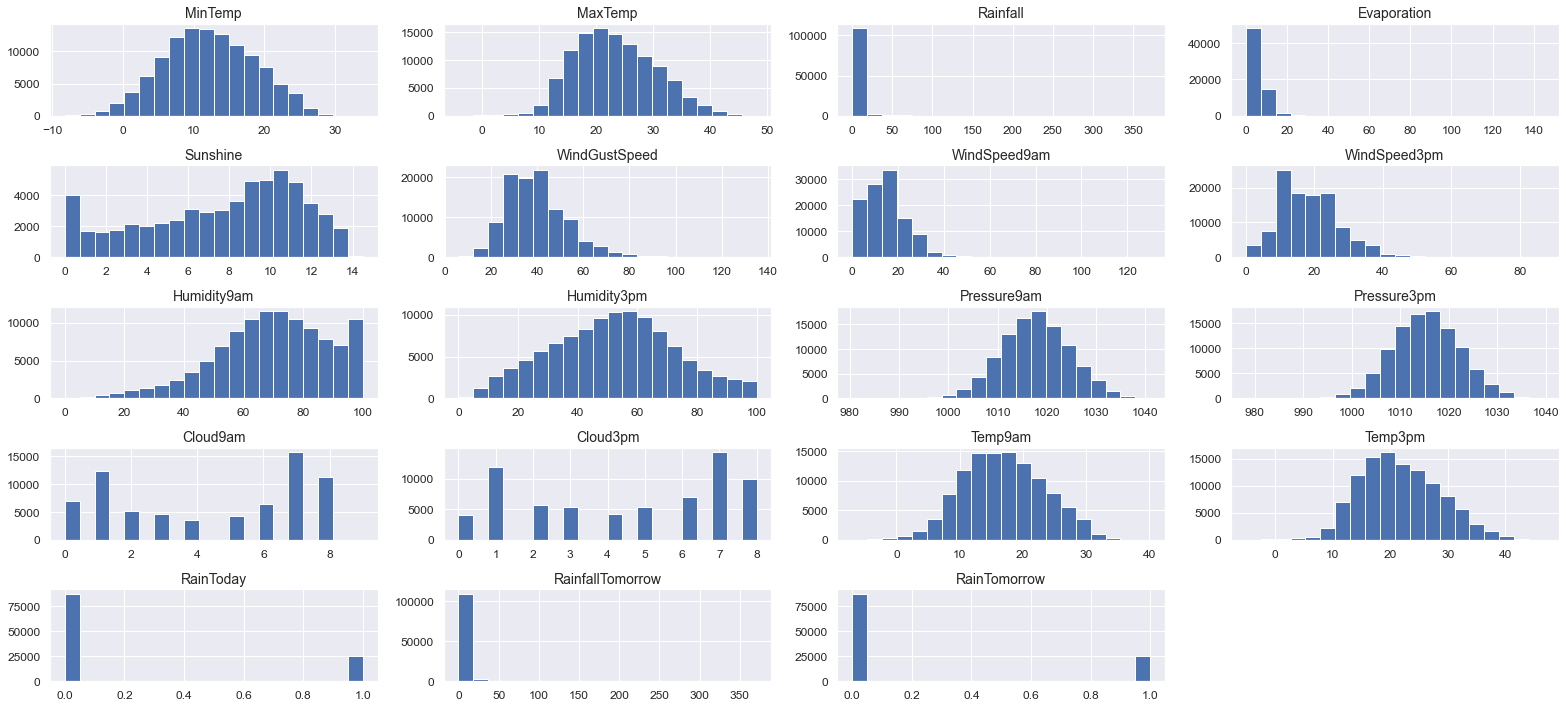

In [17]:
display_dataset_distributions(data)

In [18]:
# ETIQUETAS TENGO POR ATRIBUTO CATEGORICO
data[categoric_label].nunique()

Date            3406
Location          49
WindGustDir       16
WindDir9am        16
WindDir3pm        16
RainToday          2
RainTomorrow       2
dtype: int64

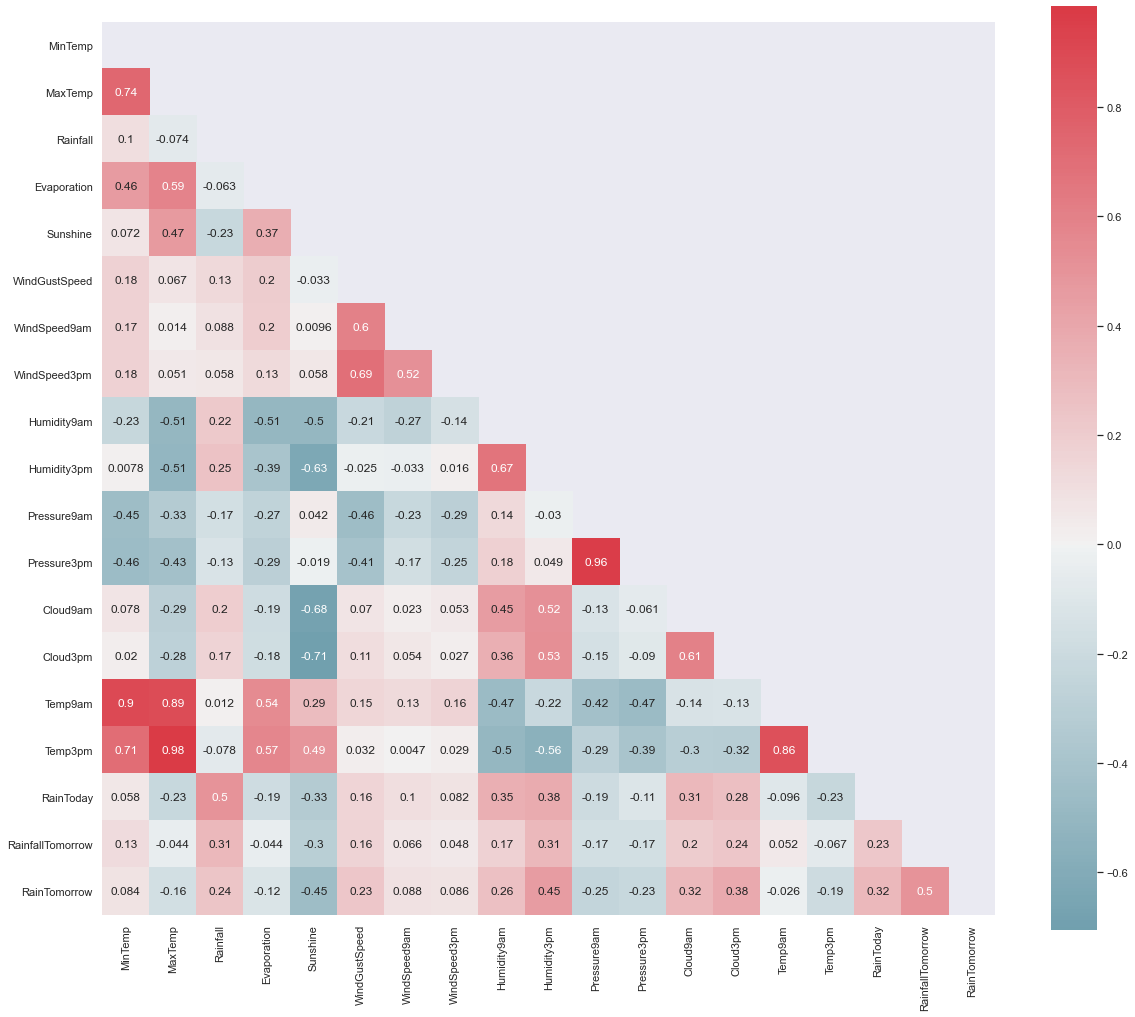

In [19]:
plot_corrMatrix(data, method = 'pearson')

# Detección de outliers

Para el tratamiento de los outliers primero se define como criterio considerar outlier todo aquel valor que se encuentre por encima de ${Q}_{3} + 1.5 IQR$ y por debajo de ${Q}_{1}-1.5 IQR$. Para visualizar la cantidad de outliers de las variables en el dataset grafico diagramas de Box & Whiskers, e histogramas y QQ-plots para evaluar que tan normales son las distribuciones de cada variable.

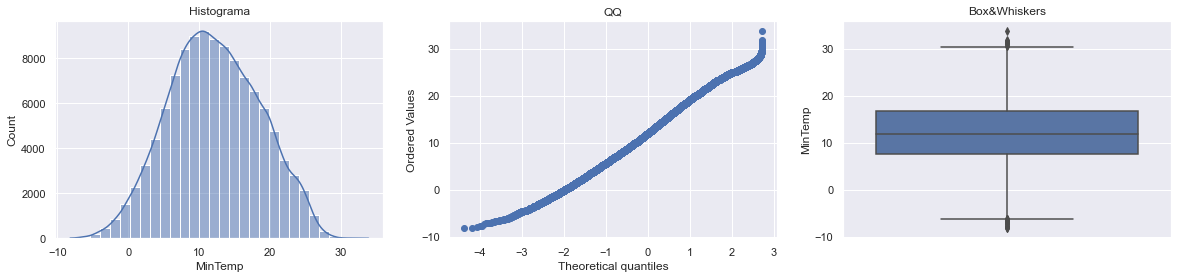

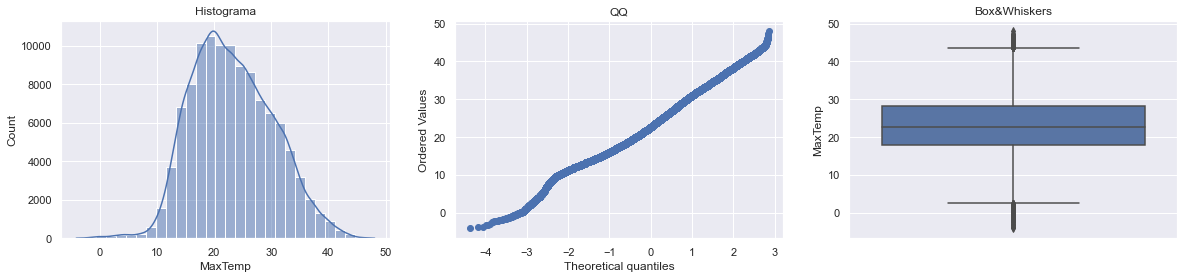

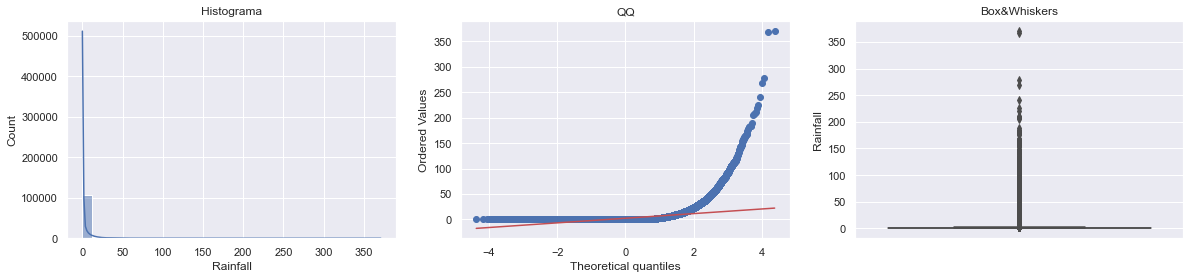

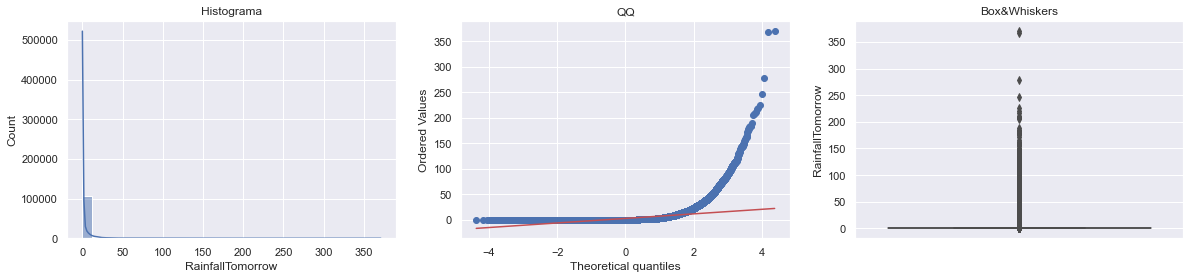

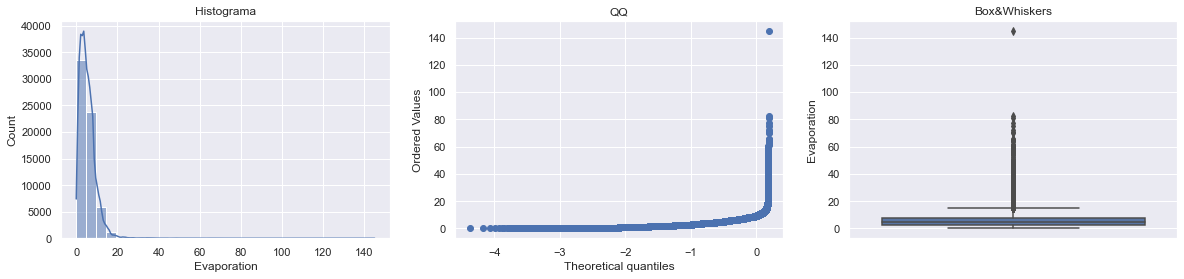

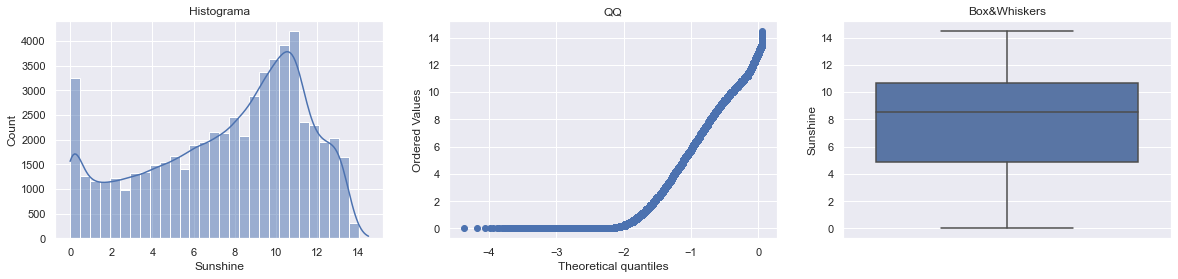

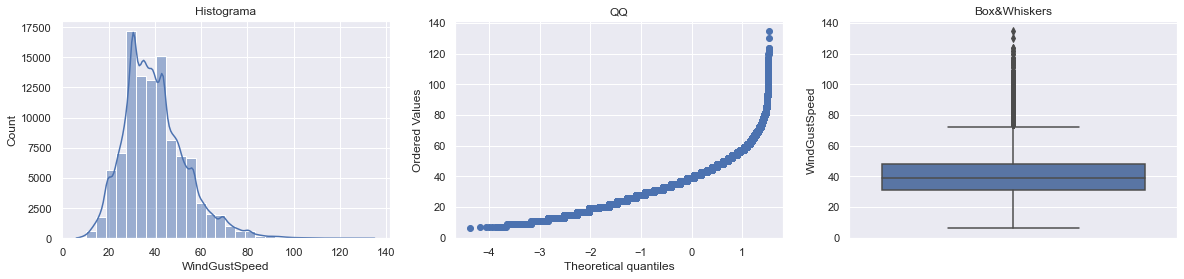

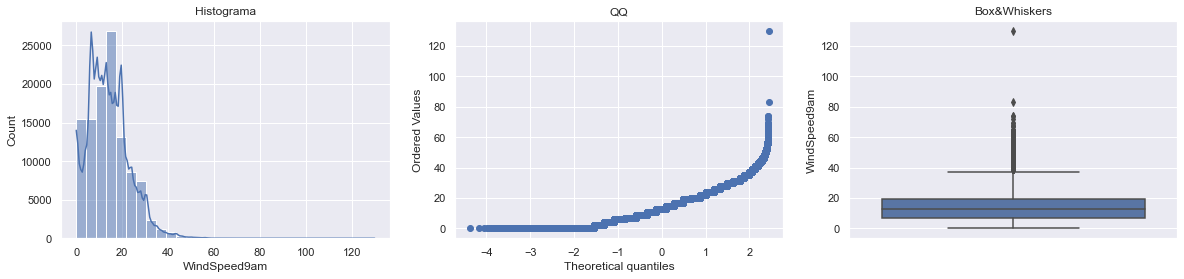

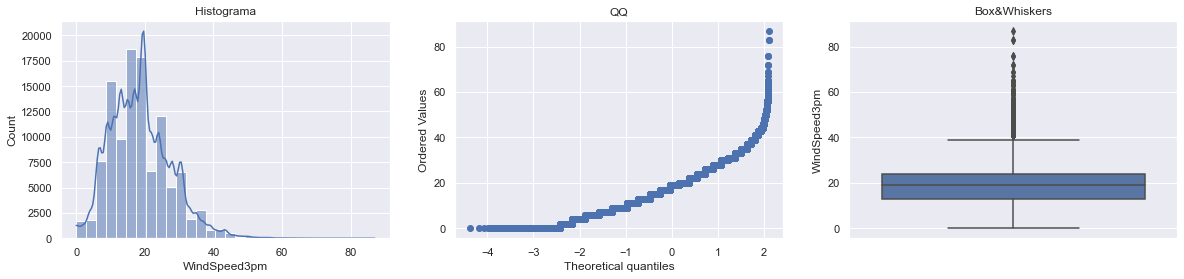

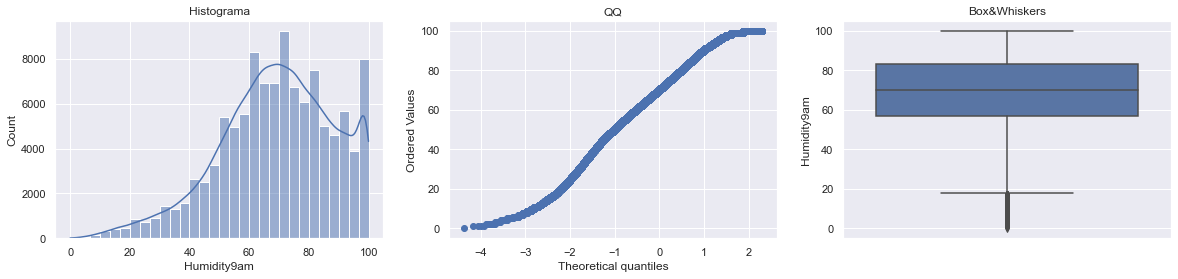

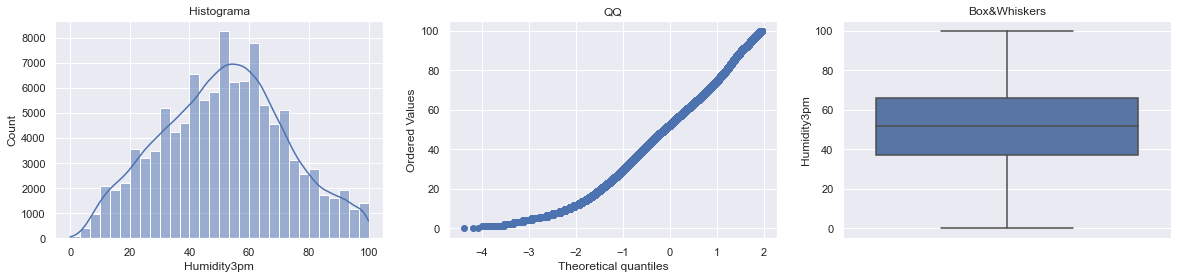

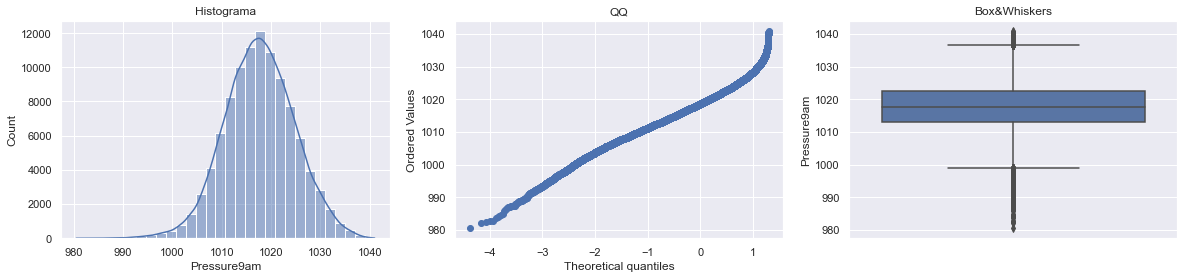

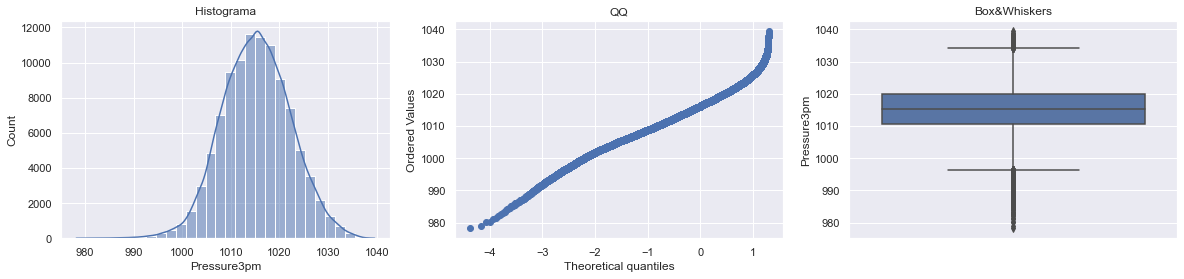

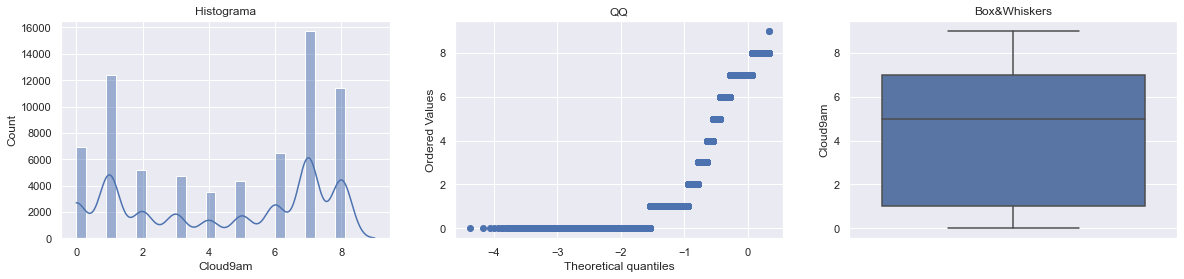

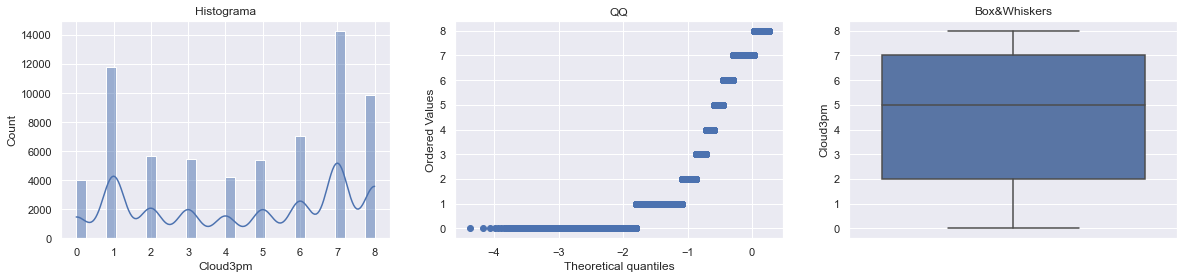

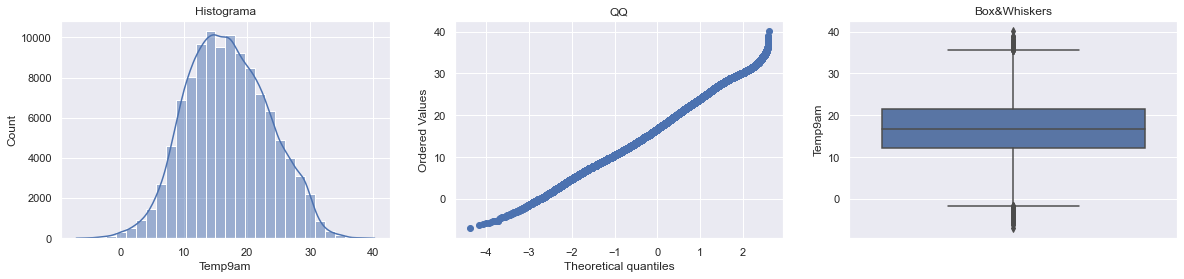

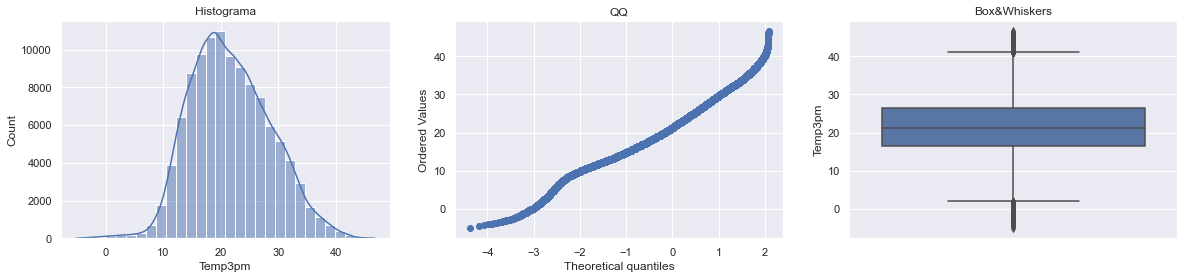

In [20]:
outlier_diagnostic_plots(data, numeric_label)

La cantidad de outliers por variables es:

In [21]:
q25, q75 = data.quantile(0.25), data.quantile(0.75) # Calculo los cuantíles
iqr = q75 - q25 # Calculo el rango intercuartílico
cutoff = iqr * 1.5 # Valor a partir del cual considero un outlier
lower,upper = q25 - cutoff, q75 + cutoff # Límite inferior y superior
((data[numeric_label]<lower) | (data[numeric_label]>upper)).sum()

<ipython-input-21-54852c0ea2ab>:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  ((data[numeric_label]<lower) | (data[numeric_label]>upper)).sum()
<ipython-input-21-54852c0ea2ab>:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  ((data[numeric_label]<lower) | (data[numeric_label]>upper)).sum()


Cloud3pm                0
Cloud9am                0
Evaporation          1560
Humidity3pm             0
Humidity9am          1132
MaxTemp               351
MinTemp                49
Pressure3pm           807
Pressure9am          1019
RainToday               0
RainTomorrow            0
Rainfall            20212
RainfallTomorrow    22718
Sunshine                0
Temp3pm               564
Temp9am               195
WindGustSpeed        2342
WindSpeed3pm         1908
WindSpeed9am         1360
dtype: int64

In [22]:
# Defino la siguiente función para detectar y reemplazar los outliers por NaN
def outliers_detection_IQR(data, labels, replace = np.NaN):
    for i in labels:
        q25, q75 = data[i].quantile(0.25), data[i].quantile(0.75) # Calculo los cuantíles
        iqr = q75 - q25 # Calculo el rango intercuartílico
        cutoff = iqr * 1.5 # Valor a partir del cual considero un outlier
        lower,upper = q25 - cutoff, q75 + cutoff # Límite inferior y superior
        data.loc[((data[i]<lower) | (data[i]>upper)),i] = replace# Asigno valores a los outliers detectados

In [23]:
# Defino las etiqueteas a las cuales voy a detectar outliers
ol_labels = ['MinTemp', 'MaxTemp', 'Humidity9am', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']

In [24]:
outliers_detection_IQR(data, ol_labels) # Detecto outliers y reemplazo

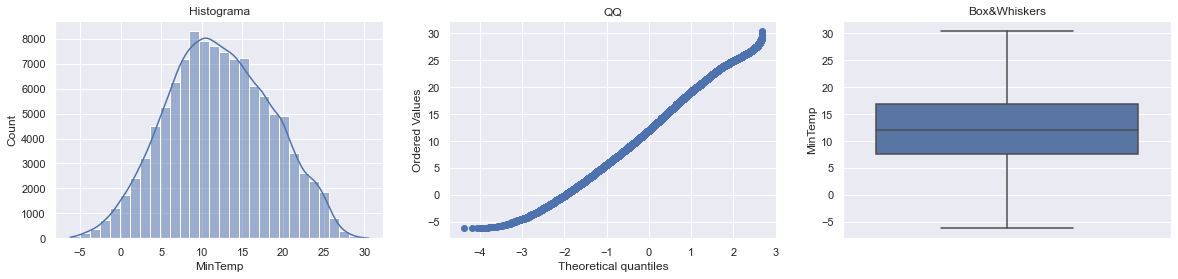

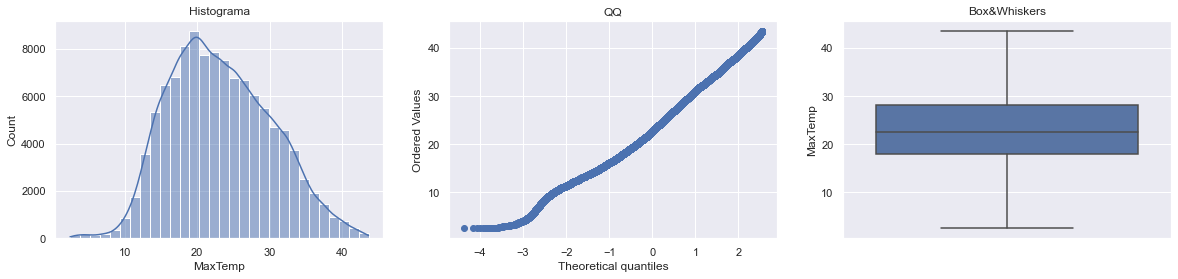

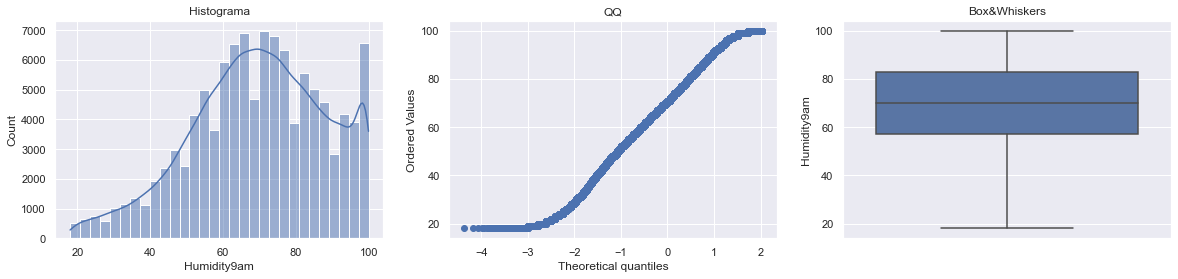

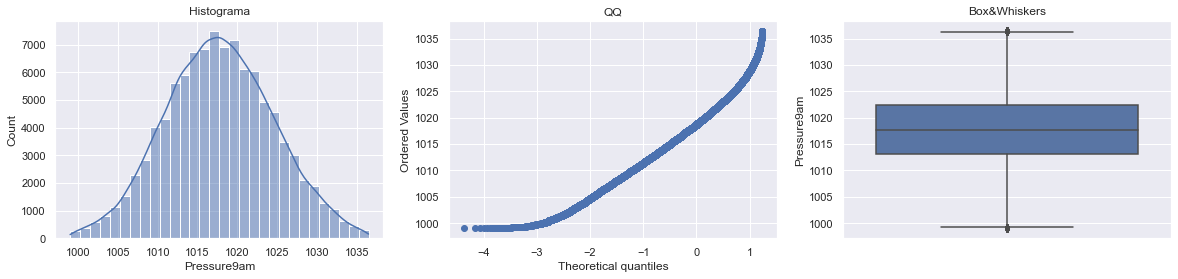

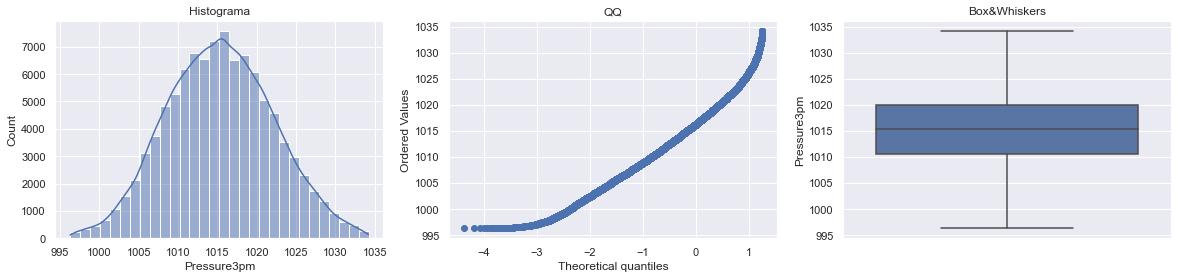

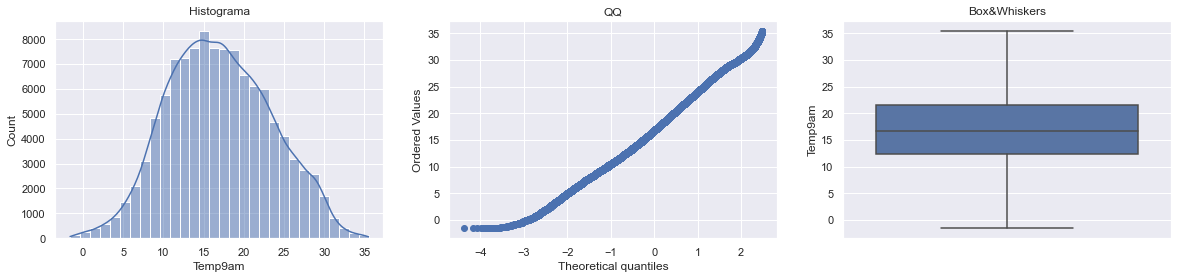

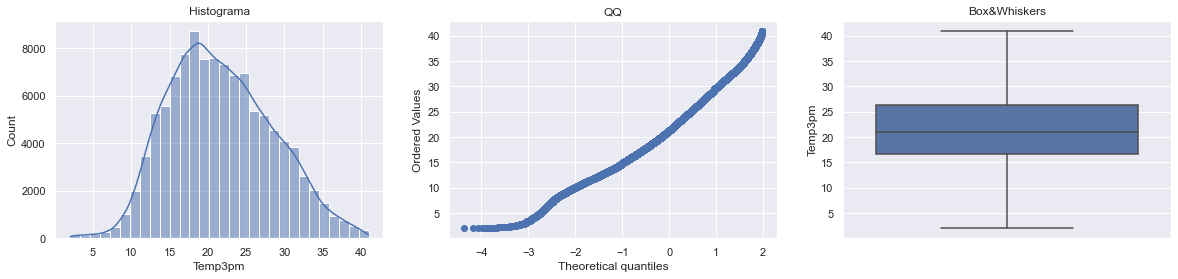

In [25]:
outlier_diagnostic_plots(data, ol_labels) # Verifico como quedaron las distribuciones

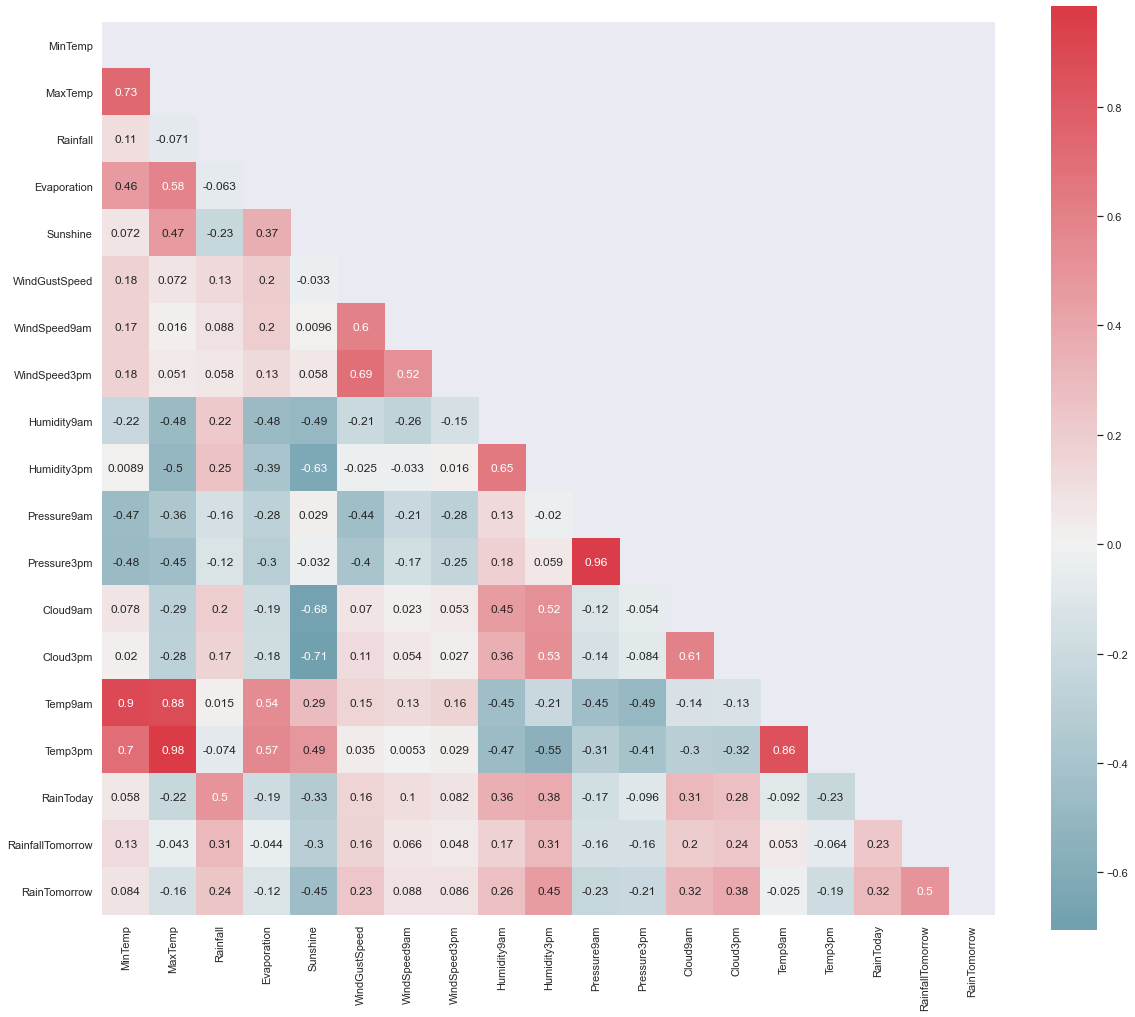

In [26]:
plot_corrMatrix(data, method = 'pearson')

# OBTENGO COORDENADAS GEOGRÁFICAS PARA CADA LOCALIDAD

In [29]:
# conda install -c conda-forge geopy
import geopy
from geopy.geocoders import Nominatim
import re

# BUSCO LAS COORDENAS GEOGRÁFICAS DE CADA NOMBRE
latitudes = []
longitudes = []
names = []
data['Latitude'] = np.zeros(len(data))
data['Longitude'] = np.zeros(len(data))

for i in data.Location.unique():
    name = i
    i = re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ', i) # RegEx para insertar un espacio antes de las mayúsculas dentro del nombre
    geolocator = Nominatim(user_agent = 'Australia')
    location = geolocator.geocode(i + ' Australia')
    
    if location is not None: # Si encuentra el nombre de la localidad, guardo los valores de lat y long
        latitud = location.latitude
        longitud = location.longitude

    else: # Si el nombre no existe: guardo NAN en lat y long
        latitud = np.NAN
        longitud = np.NAN
    
    names.append(name)
    latitudes.append(latitud)
    longitudes.append(longitud)
    
    # Asigno los valores de lat y long según el nombre de la localidad a todas las filas con ese nombre
    data.loc[data['Location'] == name, ['Latitude']] = latitud
    data.loc[data['Location'] == name, ['Longitude']] = longitud

names = np.array(names)
latitudes = np.array(latitudes)
longitudes = np.array(longitudes)

coords_df = pd.DataFrame(np.vstack((names, longitudes, latitudes)).T)

coords_df.rename(columns = {0:'Location', 1:'Longitude', 2:'Latitude'}, inplace = True)

coords_df.head(20)

Location           Longitude     Latitude
0          Albany          117.883608  -35.0247822
1           Uluru         131.0325171   -25.344857
2            Sale         147.0647902  -38.1050358
3        Canberra         149.1012676  -35.2975906
4        Richmond   142.9283602143393   -20.569655
5        Ballarat         143.8605649  -37.5623025
6    PerthAirport  115.96760765137932  -31.9406095
7      Wollongong           150.89385  -34.4243941
8      Launceston         147.1373496  -41.4340813
9       NorahHead         151.5677778  -33.2816667
10   CoffsHarbour         153.1135293  -30.2962407
11        Penrith         150.6941684  -33.7510792
12    Tuggeranong         149.0921341  -35.4209771
13        Walpole         116.7310063  -34.9776796
14  NorfolkIsland   167.9587289126371  -29.0289575
15         Darwin         130.8410469    -12.46044
16   MountGambier   140.7820067624113  -37.8246698
17    MountGinini         148.7726345  -35.5297196
18      Katherine         132.2635993  -14.4646157
19         Hobart         147.3281233  -42.8825088

C:\Users\alexb\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Latitud')

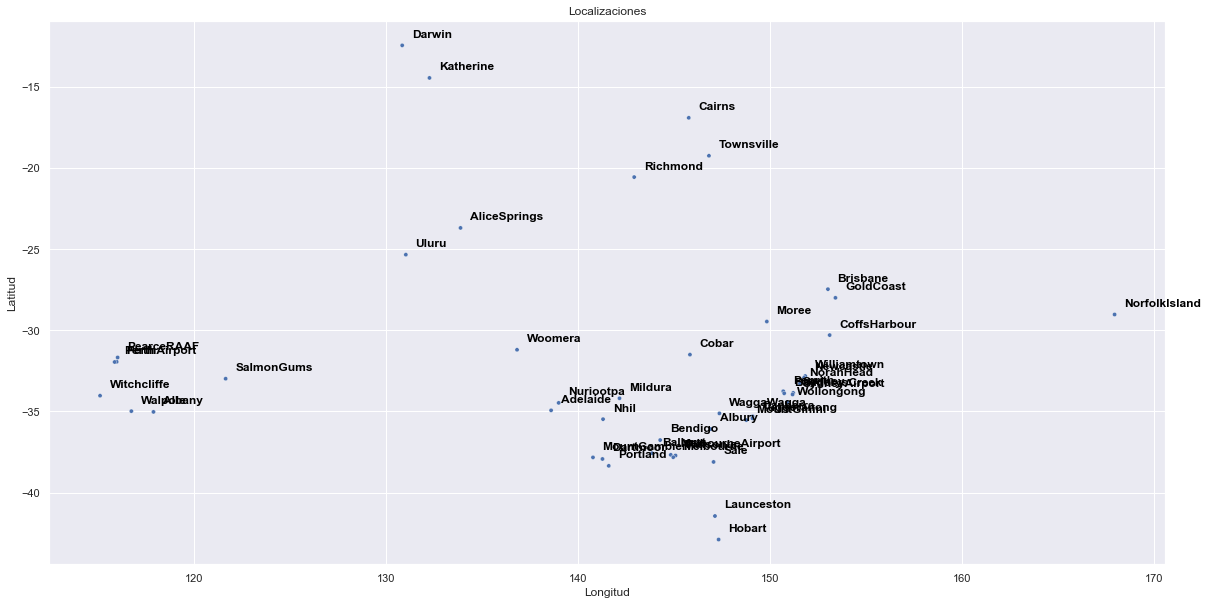

In [30]:
plt.figure(figsize=(20,10))
p1 = sns.scatterplot(longitudes,
                     latitudes,
                     size = 20,
                     legend=False)  

for line in range(0,coords_df.shape[0]):
     p1.text(longitudes[line]+0.5, latitudes[line]+0.5, 
     names[line], horizontalalignment='left', 
     size='medium', color='black', weight='semibold')

plt.title('Localizaciones')
# Set x-axis label
plt.xlabel('Longitud')
# Set y-axis label
plt.ylabel('Latitud')

<img src='https://upload.wikimedia.org/wikipedia/commons/b/b8/Australia-climate-map_MJC01.png' width="400"/>

Podemos observar que varias de las localidades están agrupadas en la zona Azul (templado). Luego hay otras en la zona más desértica del centro. Y por último, las que se encuentras ubicadas más al noter en la región tropical / ecuatorial.

Sería útil contar con una etiqueta que aproxime la pertenencia de cada ubicación a uno de estas regiones que poseen características climáticas diferentes. Por lo que aplico un algorítmo de clusterización para separarlos.

# IMPLEMENTO K-MEANS PARA AGRUPAR LAS LOCALIDADES SEGÚN SUS COORDENADAS GEOGRÁFICAS

In [31]:
from sklearn.cluster import KMeans

# Inicializo los centroides para acelerar la convergencia y que el agrupamiento represente mejor la distribución de los climas
init_centroids = np.array([[115, -35], [150, -35], [140, -15], [130, -25]])

clustering_model = KMeans(n_clusters = 4, n_init = 5, init = init_centroids) # Defino modelo para implementar Kmeans
X = np.array(coords_df[['Longitude', 'Latitude']]) 
y_pred_KMeans = clustering_model.fit_predict(X) # Clusterizo utilizando latitud y longitud de cada ciudad
coords_df['cluster'] = y_pred_KMeans

# Codificación de las etiquetas de los clusters
coords_df['cluster'].replace((0, 1, 2, 3), (2, 2, 3, 1), inplace = True)

coords_df.head()


C:\Users\alexb\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  self._check_params(X)


Location          Longitude     Latitude  cluster
0    Albany         117.883608  -35.0247822        2
1     Uluru        131.0325171   -25.344857        1
2      Sale        147.0647902  -38.1050358        2
3  Canberra        149.1012676  -35.2975906        2
4  Richmond  142.9283602143393   -20.569655        3

C:\Users\alexb\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Latitud')

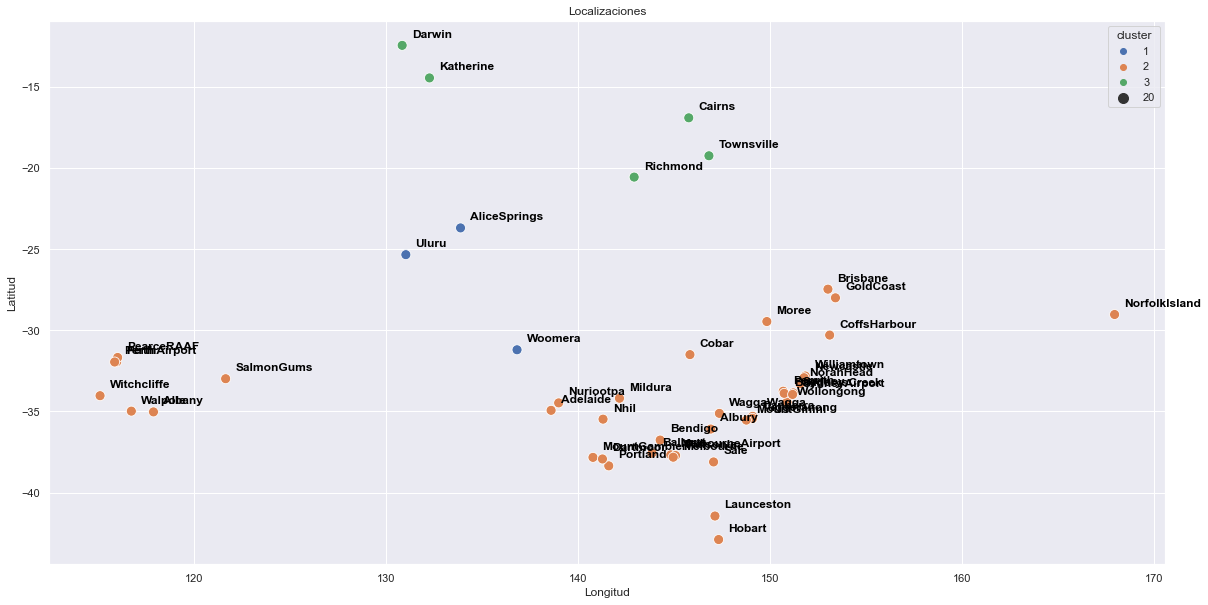

In [32]:
plt.figure(figsize=(20,10))
p1 = sns.scatterplot(longitudes,
                     latitudes,
                     size = 20,
                     sizes = (100,200),
                     legend=True,
                    hue = coords_df.cluster,
                    palette = 'deep')  

for line in range(0,coords_df.shape[0]):
     p1.text(longitudes[line]+0.5, latitudes[line]+0.5, 
     names[line], horizontalalignment='left', 
     size='medium', color='black', weight='semibold')

plt.title('Localizaciones')
# Set x-axis label
plt.xlabel('Longitud')
# Set y-axis label
plt.ylabel('Latitud')

De la clusterización original obtenida podemos clasificar: 

**0 y 1**: Clima templado

**2**: Clima tropical / ecuatorial

**3**: Clima desértico

Para realizar una codificación de manera ordinal, redefiní las etiquetas de los clústers de la siguiente manera:

**3**: Clima tropical / ecuatorial

**2**: Clima templado

**1**: Clima desértico

Tomando como criterio que a mayor número implica mayor cantidad de precipitaciones en esa clasificación del clima.

In [33]:
# Asigno los valores las etiquetas del cluster correspondiente a cada observación
j = 0
for i in coords_df.Location:
    data.loc[data['Location'] == i, ['Cluster']] = coords_df[coords_df['Location'] == i].at[j, 'cluster']
    j=j+1

In [34]:
data.head()

Date  Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
110518  2014-06-29    Albany      9.5     16.9       0.4          0.6   
143981  2013-06-08     Uluru     13.6     19.6       0.0          NaN   
63788   2016-05-19      Sale      7.7     20.8       0.0          NaN   
63210   2014-10-19      Sale      8.8     28.4       0.0          NaN   
46013   2008-12-31  Canberra     13.5     24.0       0.0          9.8   

        Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
110518       5.6         NaN            NaN          N         NE   
143981       NaN           E           33.0          E          E   
63788        NaN         NaN            NaN          W         NW   
63210        NaN          NW           43.0         NW         NW   
46013       13.4         WNW           44.0        WNW        WNW   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
110518           6.0           4.0         84.0         59.0       1028.1   
143981          24.0          17.0         88.0         65.0       1025.4   
63788           13.0          33.0         56.0         53.0       1011.6   
63210            9.0          28.0         66.0         27.0       1021.2   
46013           19.0          24.0         38.0         25.0       1002.8   

        Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
110518       1024.7       7.0       7.0     11.2     16.1          0   
143981       1020.9       NaN       NaN     14.6     19.0          0   
63788        1008.5       1.0       7.0     17.4     18.5          0   
63210        1017.5       6.0       8.0     17.5     26.4          0   
46013        1002.8       1.0       1.0     17.3     23.0          0   

        RainfallTomorrow  RainTomorrow   Latitude   Longitude  Cluster  
110518               0.0             0 -35.024782  117.883608      2.0  
143981               0.0             0 -25.344857  131.032517      1.0  
63788                1.8             1 -38.105036  147.064790      2.0  
63210                0.0             0 -38.105036  147.064790      2.0  
46013                0.0             0 -35.297591  149.101268      2.0

# Escalado de características


Como luego voy a utilizar métodos de imputación que consideran la distancias entre las distintas observaciones como KNN, primero escalo las características.

In [35]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
vars_to_scal = ['MinTemp', 'MaxTemp', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'Latitude', 'Longitude']
aux_data_scaled = pd.DataFrame(minmax_scaler.fit_transform(data[vars_to_scal]), columns = vars_to_scal)

In [36]:
data.drop(columns = vars_to_scal, inplace = True)
data[vars_to_scal] = aux_data_scaled.values

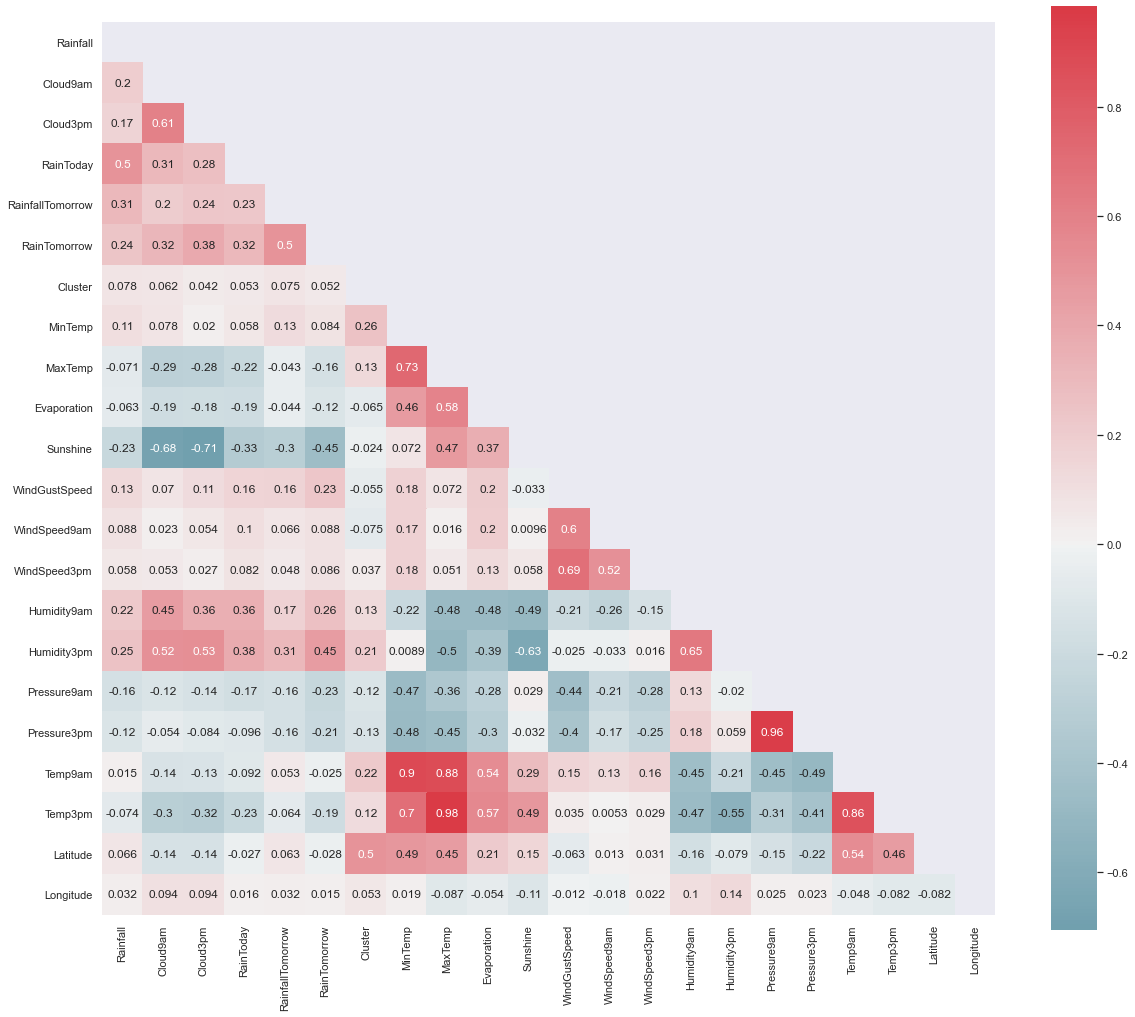

In [37]:
plot_corrMatrix(data, method = 'pearson')

# Imputación de datos faltantes

In [38]:
# Cantidad de datos faltantes
data.isna().sum()

Date                    0
Location                0
Rainfall                0
WindGustDir          7313
WindDir9am           7657
WindDir3pm           2937
Cloud9am            42060
Cloud3pm            44892
RainToday               0
RainfallTomorrow        0
RainTomorrow            0
Cluster                 0
MinTemp               407
MaxTemp               597
Evaporation         47850
Sunshine            53523
WindGustSpeed        7268
WindSpeed9am          839
WindSpeed3pm         2014
Humidity9am          2326
Humidity3pm          2775
Pressure9am         12067
Pressure3pm         11880
Temp9am               726
Temp3pm              2666
Latitude                0
Longitude               0
dtype: int64

In [39]:
# Porcentaje de datos faltantes
data.isna().sum()*100/len(data)

Date                 0.000000
Location             0.000000
Rainfall             0.000000
WindGustDir          6.494902
WindDir9am           6.800419
WindDir3pm           2.608441
Cloud9am            37.354791
Cloud3pm            39.869978
RainToday            0.000000
RainfallTomorrow     0.000000
RainTomorrow         0.000000
Cluster              0.000000
MinTemp              0.361469
MaxTemp              0.530214
Evaporation         42.497069
Sunshine            47.535436
WindGustSpeed        6.454936
WindSpeed9am         0.745142
WindSpeed3pm         1.788696
Humidity9am          2.065793
Humidity3pm          2.464564
Pressure9am         10.717077
Pressure3pm         10.550996
Temp9am              0.644783
Temp3pm              2.367757
Latitude             0.000000
Longitude            0.000000
dtype: float64

Para realizar la imputación de datos faltantes, primero agrupo los datos por localidad, ya que las condiciones climáticas de cada lugar pueden ser muy diferentes entre sí. Luego tomo las siguientes consideraciones:

Descarto las realizaciones que tienen NaN en *Rainfall* ya que son pocos datos (< 5%) y no es conveniente imputar la variable a predecir.

Las variables que tienen menos del 15% de datos faltantes las imputo por la **media**. se calcula una media por localidad.

Para imputar los datos faltantes de las variables que tienen más del 15% NaN, utilizo **MICE (Multiple imputations by chained equations)**

## Imputación por media

In [40]:
# Defino un transformador por media

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin

Defino **CustomMeanTransformer**: 

Cuando *fit* es llamado, este transformador genera una matriz de promedios con las siguientes entradas: Localidad y feature. 

Cuando *transform* es llamado, el transformador reemplaza todos los NaN de las variables especificadas en *vars_to_replace* considerando a que localidad pertenecen, buscando el promedio en la matriz generada previamente.

Cuando *fit_transform* es llamado, el transformador realiza ambos pasos previos.

In [42]:
# class CustomMeanTransformer(BaseEstimator, TransformerMixin):
#     def __init__ (self):
#         print('\n init() called. \n')

#     def fit(self, X, y = None):
#         print('\n fit() called. \n') 
        
#         labels = list(X.columns)
#         if 'Location' in labels: labels.remove('Location')
            
#         #Creo matriz con valores promedio
#         X_replaced_mean = X.sort_values(by=['Location']) # Ordeno los valores
#         X_replaced_mean.set_index(['Location'], inplace = True) # Agrego múlti índice

#         mean_matrix = pd.DataFrame(index = X['Location'].unique(), columns = X_replaced_mean.columns) # Creo un DataFrame vacío donde se van a almacenar los promedios

#         for i in X['Location'].unique():
#             mean_matrix.loc[i] = X_replaced_mean.loc[i].mean()
            
#         return self
        
    
#     def transform(self, X, y = None):
#         print('\n fit_transform() called. \n')      
        
#         labels = list(X.columns)
#         if 'Location' in labels: labels.remove('Location')

        
#         # Reemplazo los valores NaN en X por el correspondiente en la matríz de promedios
#         for loc in X['Location'].unique():
#             for var in labels:
#                 X_replaced_mean.loc[loc, var].fillna(mean_matrix.loc[loc, var], inplace = True)
                
#         # Reemplazo los valores NaN restantes en X_replaced_mean por la media de cada columna
        
# #         for var in X_replaced_mean.columns:
# #             X_replaced_mean.loc[:, var].fillna(X_replaced_mean[var].mean(), inplace = True)
        
#         # Redefino los índices de el dataframe de datos
#         X_replaced_mean.reset_index(inplace = True) # Vuelvo a poner los indices como columnas
        
#         return X_replaced_mean  
        
#     def fit_transform(self, X, y = None):
#         print('\n fit_transform() called. \n')      
#         labels = list(X.columns)
#         if 'Location' in labels: labels.remove('Location')

        
#         # Creo matriz con valores promedio
#         X_replaced_mean = X.sort_values(by=['Location']) # Ordeno los valores
#         X_replaced_mean.set_index(['Location'], inplace = True) # Agrego múlti índice
#         mean_matrix = pd.DataFrame(index = X['Location'].unique(), columns = X_replaced_mean.columns) # Creo un DataFrame vacío donde se van a almacenar los promedio
#         for i in X['Location'].unique():
#             mean_matrix.loc[i] = X_replaced_mean.loc[i].mean()
            
#         # Reemplazo los valores NaN en X por el correspondiente en la matríz de promedios
#         for loc in X['Location'].unique():
#             for var in labels:
#                 X_replaced_mean.loc[loc, var].fillna(mean_matrix.loc[loc, var], inplace = True)

#         # Reemplazo los valores NaN restantes en X_replaced_mean por la media de cada columna
        
# #         for var in X_replaced_mean.columns:
# #             X_replaced_mean.loc[:, var].fillna(X_replaced_mean[var].mean(), inplace = True)
                
#         # Redefino los índices de el dataframe de datos
#         X_replaced_mean.reset_index(inplace = True) # Vuelvo a poner los indices como columnas
        
#         return X_replaced_mean 

In [43]:
class CustomMeanTransformer(BaseEstimator, TransformerMixin):
    def __init__ (self):
        print('\n init() called. \n')

    def fit(self, X, labels_to_transform, y = None):
        print('\n fit() called. \n') 
        
        labels = labels_to_transform

  
        # Creo matriz con valores promedio
        X_replaced_mean = X.sort_values(by=['Location']) # Ordeno los valores
        X_replaced_mean.set_index(['Location'], inplace = True) # Agrego múlti índice
        self.mean_matrix = pd.DataFrame(index = X['Location'].unique(), columns = X_replaced_mean.columns) # Creo un DataFrame vacío donde se van a almacenar los promedio
        for i in X['Location'].unique():
            self.mean_matrix.loc[i] = X_replaced_mean.loc[i].mean()
            
        return self
        
    
    def transform(self, X, labels_to_transform, y = None):
        print('\n fit_transform() called. \n')      
        
        labels = labels_to_transform

        # Reemplazo los valores NaN en X por el correspondiente en la matríz de promedios
        for loc in X['Location'].unique():
            for var in labels:
                X_replaced_mean.loc[loc, var].fillna(self.mean_matrix.loc[loc, var], inplace = True)
                
       
        # Redefino los índices de el dataframe de datos
        X_replaced_mean.reset_index(inplace = True) # Vuelvo a poner los indices como columnas
        
        return X_replaced_mean  
        
        
    def fit_transform(self, X, labels_to_transform,y = None):
        print('\n fit_transform() called. \n')      
        labels = labels_to_transform

        
        # Creo matriz con valores promedio
        X_replaced_mean = X.sort_values(by=['Location']) # Ordeno los valores
        X_replaced_mean.set_index(['Location'], inplace = True) # Agrego múlti índice
        self.mean_matrix = pd.DataFrame(index = X['Location'].unique(), columns = X_replaced_mean.columns) # Creo un DataFrame vacío donde se van a almacenar los promedio
        for i in X['Location'].unique():
            self.mean_matrix.loc[i] = X_replaced_mean.loc[i].mean()
            
        # Reemplazo los valores NaN en X por el correspondiente en la matríz de promedios
        for loc in X['Location'].unique():
            for var in labels:
                X_replaced_mean.loc[loc, var].fillna(self.mean_matrix.loc[loc, var], inplace = True)
               
        # Redefino los índices de el dataframe de datos
        X_replaced_mean.reset_index(inplace = True) # Vuelvo a poner los indices como columnas
        
        return X_replaced_mean 

In [44]:
# PRUEBO EL TRANSFORMADOR DE FORMA AISLADA (SIN PIPELINE)

In [45]:
# Inicializo, ajusto y entreno con el custom transformer
custom_transformer = CustomMeanTransformer()
#custom_transformer.fit(data)

# Variables a reemplazar
# Le paso Location ya que el transformador utiliza las ciudades como índice, esa variable no será imputada
vars_to_rep = ['MinTemp', 'MaxTemp',
       'WindGustSpeed', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm']
data_custom_transformed = custom_transformer.fit_transform(X = data, labels_to_transform = vars_to_rep)


 init() called. 


 fit_transform() called. 



C:\Users\alexb\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [46]:
data_custom_transformed.isna().sum()

Location                0
Date                    0
Rainfall                0
WindGustDir          7313
WindDir9am           7657
WindDir3pm           2937
Cloud9am            42060
Cloud3pm            44892
RainToday               0
RainfallTomorrow        0
RainTomorrow            0
Cluster                 0
MinTemp                 0
MaxTemp                 0
Evaporation         47850
Sunshine            53523
WindGustSpeed        4724
WindSpeed9am            0
WindSpeed3pm            0
Humidity9am             0
Humidity3pm             0
Pressure9am          9341
Pressure3pm          9341
Temp9am                 0
Temp3pm                 0
Latitude                0
Longitude               0
dtype: int64

In [47]:
# Matríz de medias utilizada para imputar los datos faltantes
custom_transformer.mean_matrix

Date  Rainfall WindGustDir WindDir9am WindDir3pm  Cloud9am  \
Albany            NaN  2.241346         NaN        NaN        NaN  5.184719   
Uluru             NaN  0.729734         NaN        NaN        NaN  5.586207   
Sale              NaN  1.523517         NaN        NaN        NaN  5.330939   
Canberra          NaN  1.769978         NaN        NaN        NaN    4.9017   
Richmond          NaN  2.047202         NaN        NaN        NaN      6.24   
Ballarat          NaN  1.681807         NaN        NaN        NaN  5.804467   
PerthAirport      NaN  1.785259         NaN        NaN        NaN  3.411935   
Wollongong        NaN  3.597687         NaN        NaN        NaN  6.221154   
Launceston        NaN  2.064986         NaN        NaN        NaN  6.319039   
NorahHead         NaN  3.367725         NaN        NaN        NaN       NaN   
CoffsHarbour      NaN  5.212765         NaN        NaN        NaN  4.383051   
Penrith           NaN  2.170904         NaN        NaN        NaN       NaN   
Tuggeranong       NaN  2.161168         NaN        NaN        NaN       NaN   
Walpole           NaN  2.887349         NaN        NaN        NaN       NaN   
NorfolkIsland     NaN  3.055532         NaN        NaN        NaN  5.013829   
Darwin            NaN  5.122988         NaN        NaN        NaN  4.289973   
MountGambier      NaN  2.095211         NaN        NaN        NaN  5.501922   
MountGinini       NaN  3.308599         NaN        NaN        NaN       NaN   
Katherine         NaN  3.372647         NaN        NaN        NaN  2.590204   
Hobart            NaN  1.652071         NaN        NaN        NaN  4.819753   
Witchcliffe       NaN  2.992949         NaN        NaN        NaN       NaN   
Sydney            NaN  3.390302         NaN        NaN        NaN  4.202782   
Woomera           NaN  0.508855         NaN        NaN        NaN   2.49527   
Portland          NaN  2.430516         NaN        NaN        NaN  6.357771   
AliceSprings      NaN  0.860646         NaN        NaN        NaN  2.828204   
BadgerysCreek     NaN  2.147551         NaN        NaN        NaN       NaN   
PearceRAAF        NaN  1.659142         NaN        NaN        NaN  3.683652   
Townsville        NaN  3.631856         NaN        NaN        NaN  4.254102   
Nhil              NaN  0.938095         NaN        NaN        NaN       NaN   
Perth             NaN  1.870607         NaN        NaN        NaN  3.360911   
Cairns            NaN  5.745296         NaN        NaN        NaN  4.570044   
Bendigo           NaN   1.55561         NaN        NaN        NaN  4.376562   
MelbourneAirport  NaN  1.378965         NaN        NaN        NaN  5.264182   
Adelaide          NaN  1.626997         NaN        NaN        NaN       NaN   
Brisbane          NaN  3.165739         NaN        NaN        NaN   3.91173   
WaggaWagga        NaN  1.732444         NaN        NaN        NaN  3.844828   
SalmonGums        NaN  1.014778         NaN        NaN        NaN       NaN   
Williamtown       NaN  3.549184         NaN        NaN        NaN  4.471734   
Nuriootpa         NaN  1.297826         NaN        NaN        NaN  4.657838   
Watsonia          NaN  1.842172         NaN        NaN        NaN  5.246633   
Cobar             NaN  1.102272         NaN        NaN        NaN   3.28167   
SydneyAirport     NaN  3.058769         NaN        NaN        NaN  4.290268   
Moree             NaN  1.588924         NaN        NaN        NaN  3.241268   
Melbourne         NaN  1.819837         NaN        NaN        NaN  5.207046   
Albury            NaN   2.00758         NaN        NaN        NaN  6.439961   
Dartmoor          NaN  2.173134         NaN        NaN        NaN       NaN   
GoldCoast         NaN  3.742821         NaN        NaN        NaN       NaN   
Mildura           NaN  0.918968         NaN        NaN        NaN  3.315653   
Newcastle         NaN  2.897899         NaN        NaN        NaN  4.095411   

                  Cloud3pm RainToday RainfallTomorrow RainTomorrow

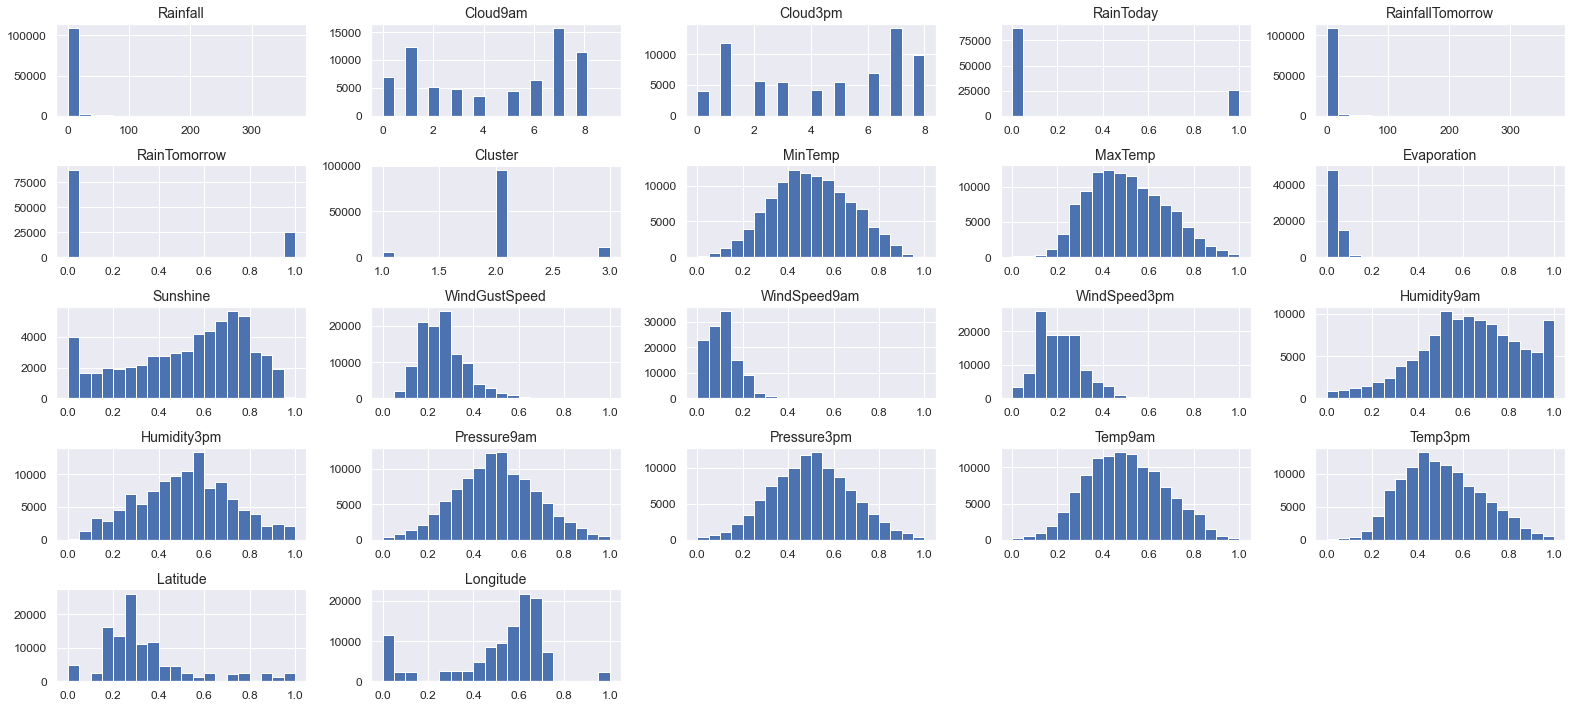

In [48]:
display_dataset_distributions(data_custom_transformed)

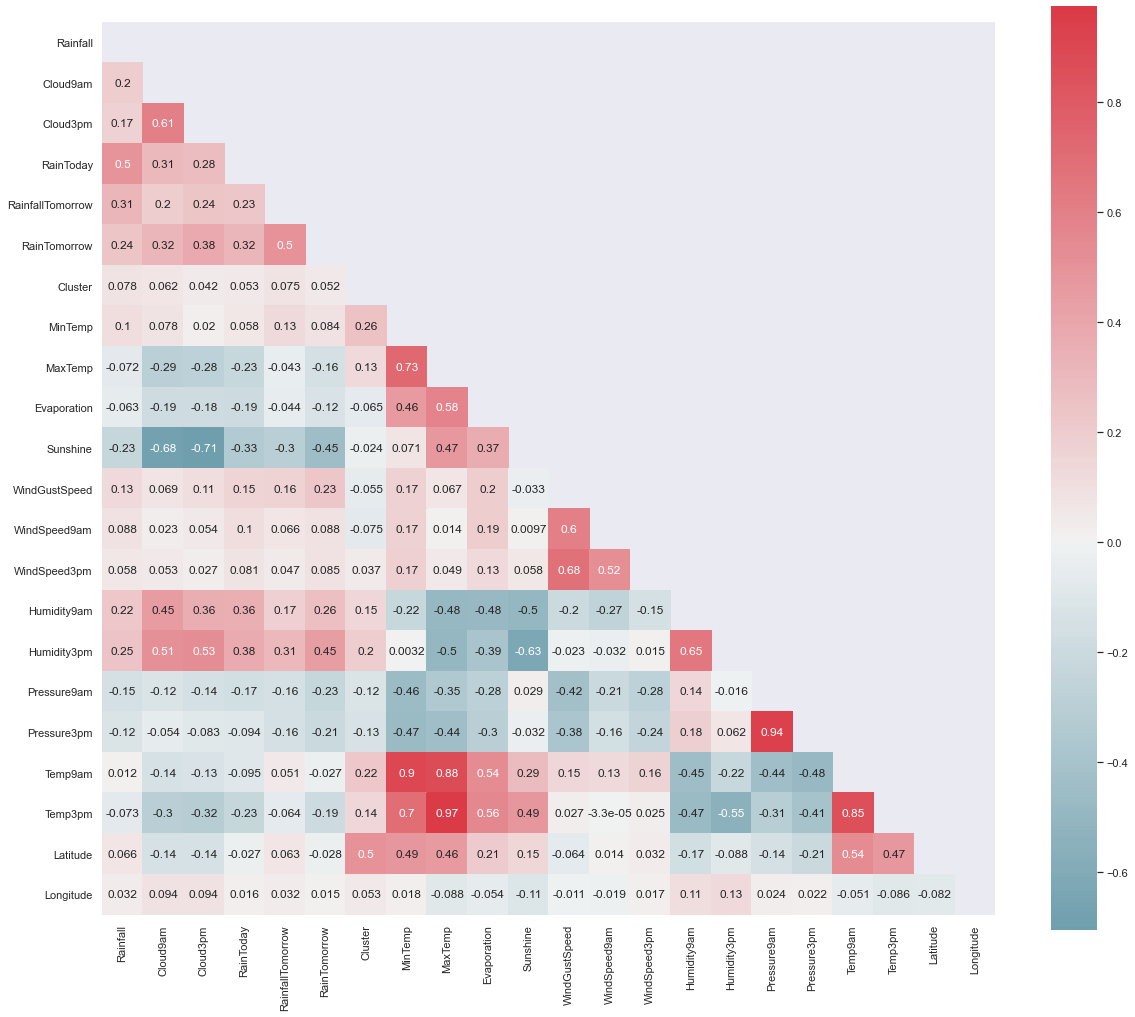

In [49]:
plot_corrMatrix(data_custom_transformed, method = 'pearson')

## Imputación por KNN

Los datos faltantes luego de la imputación por media, los imputo utilizando KNN.

In [50]:
vars_with_missing = ['WindGustSpeed', 'Pressure9am', 'Pressure3pm']
aux_vars = ['WindSpeed9am', 'WindSpeed3pm', 'MinTemp', 'MaxTemp']
vars_to_KNN = vars_with_missing + aux_vars
vars_to_KNN

['WindGustSpeed',
 'Pressure9am',
 'Pressure3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'MinTemp',
 'MaxTemp']

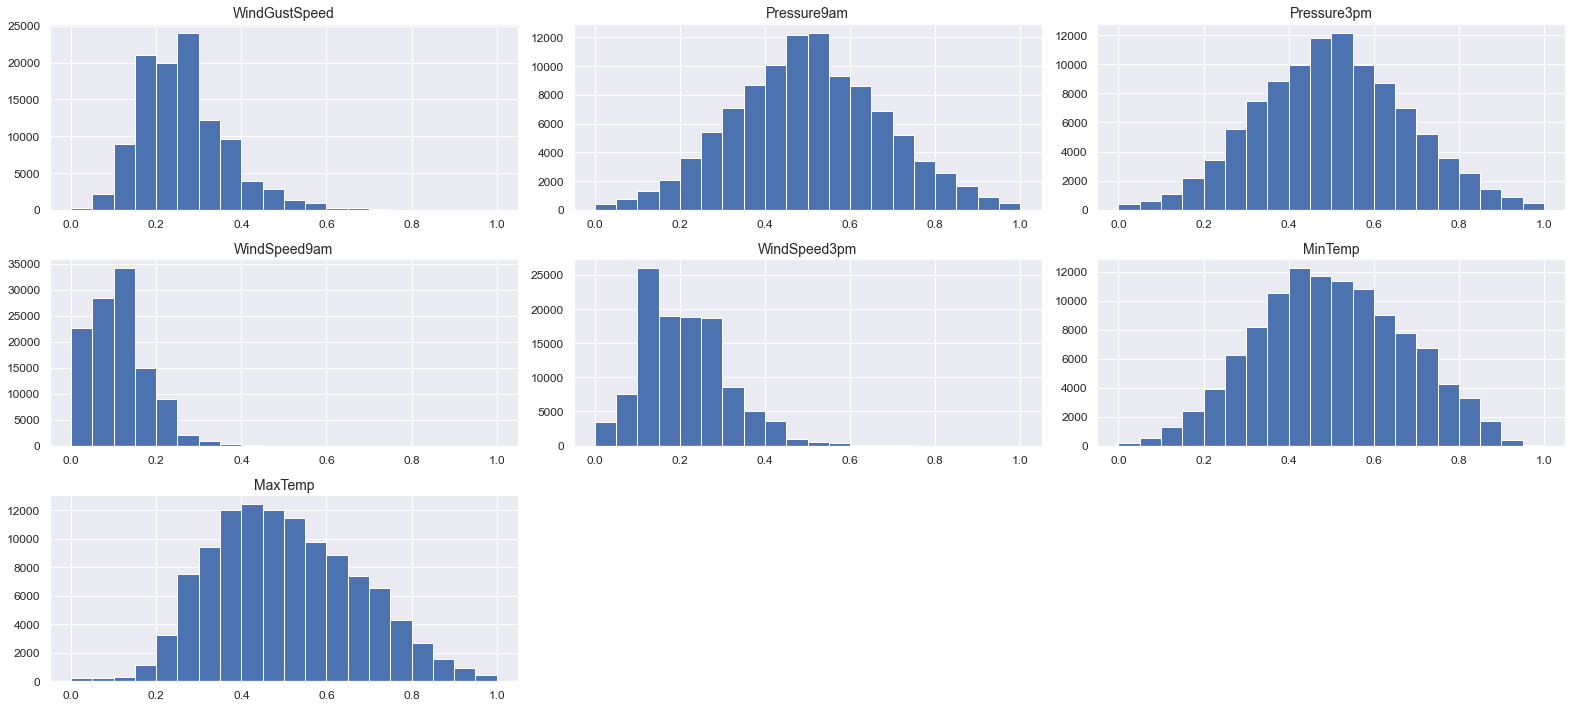

In [52]:
# Distribuciones previas a la imputación de datos
display_dataset_distributions(data_custom_transformed[vars_to_KNN])

In [53]:
# Cantidad de datos faltantes antes de la imputación
data_custom_transformed[vars_to_KNN].isna().sum()

WindGustSpeed    4724
Pressure9am      9341
Pressure3pm      9341
WindSpeed9am        0
WindSpeed3pm        0
MinTemp             0
MaxTemp             0
dtype: int64

In [54]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(missing_values=np.nan, add_indicator=True, n_neighbors = 3)
data_imputed_KNN = imputer.fit_transform(data_custom_transformed[vars_to_KNN])

In [55]:
# Genero nuevas etiquetas para los datos etiquetados
aux = vars_with_missing.copy()
for i in aux:
    vars_to_KNN.append(i + ' KNNindicator')

In [56]:
vars_to_KNN

['WindGustSpeed',
 'Pressure9am',
 'Pressure3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'MinTemp',
 'MaxTemp',
 'WindGustSpeed KNNindicator',
 'Pressure9am KNNindicator',
 'Pressure3pm KNNindicator']

In [57]:
data_imputed_KNN = pd.DataFrame(data_imputed_KNN, columns = vars_to_KNN)

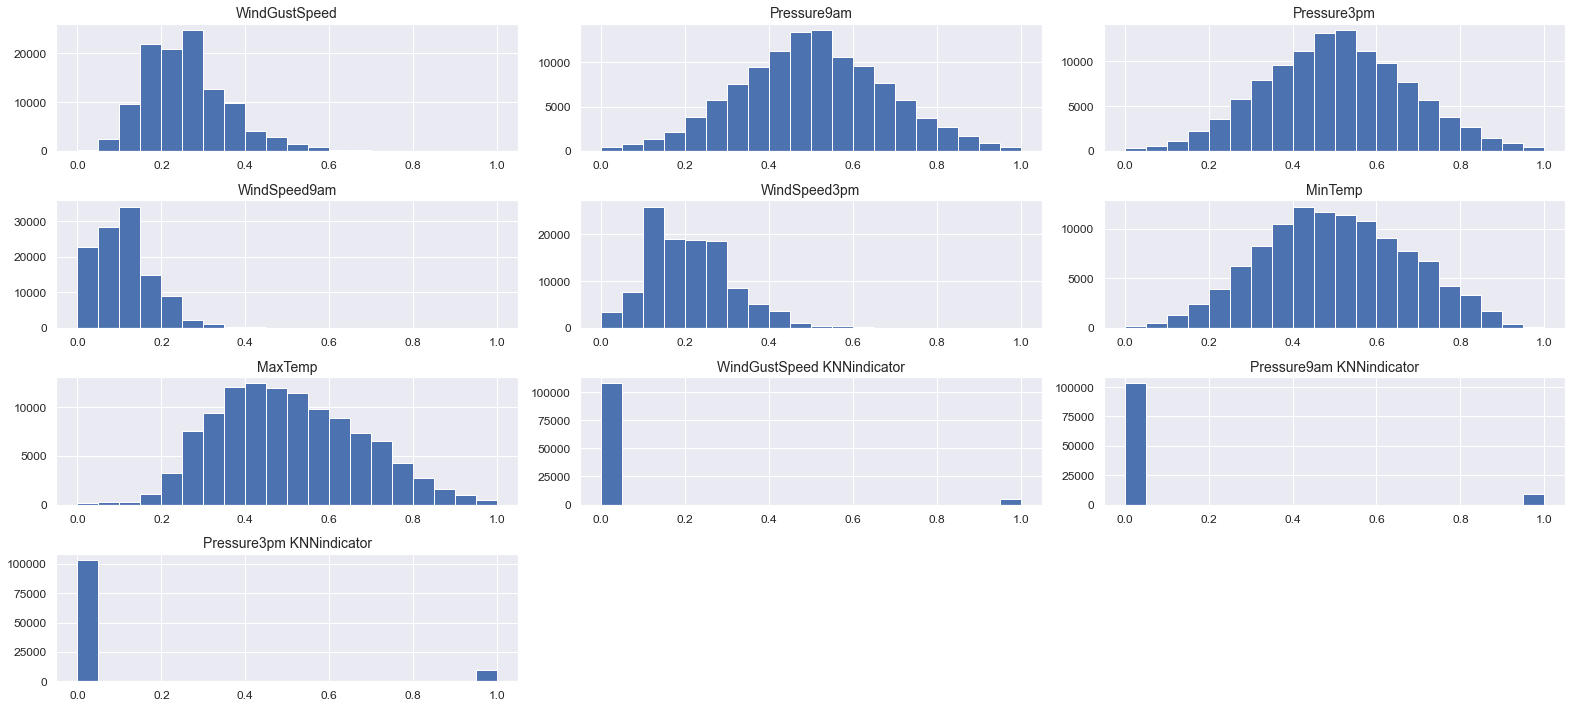

In [58]:
display_dataset_distributions(data_imputed_KNN)

In [59]:
data_imputed_KNN.isna().sum()

WindGustSpeed                 0
Pressure9am                   0
Pressure3pm                   0
WindSpeed9am                  0
WindSpeed3pm                  0
MinTemp                       0
MaxTemp                       0
WindGustSpeed KNNindicator    0
Pressure9am KNNindicator      0
Pressure3pm KNNindicator      0
dtype: int64

In [60]:
data_custom_transformed.drop(columns = vars_with_missing + aux_vars, inplace = True) # Elimino columnas originales que fueron imputadas con KNN
data_custom_transformed[vars_to_KNN] = data_imputed_KNN.values # Agrego las nuevas columnas al data set

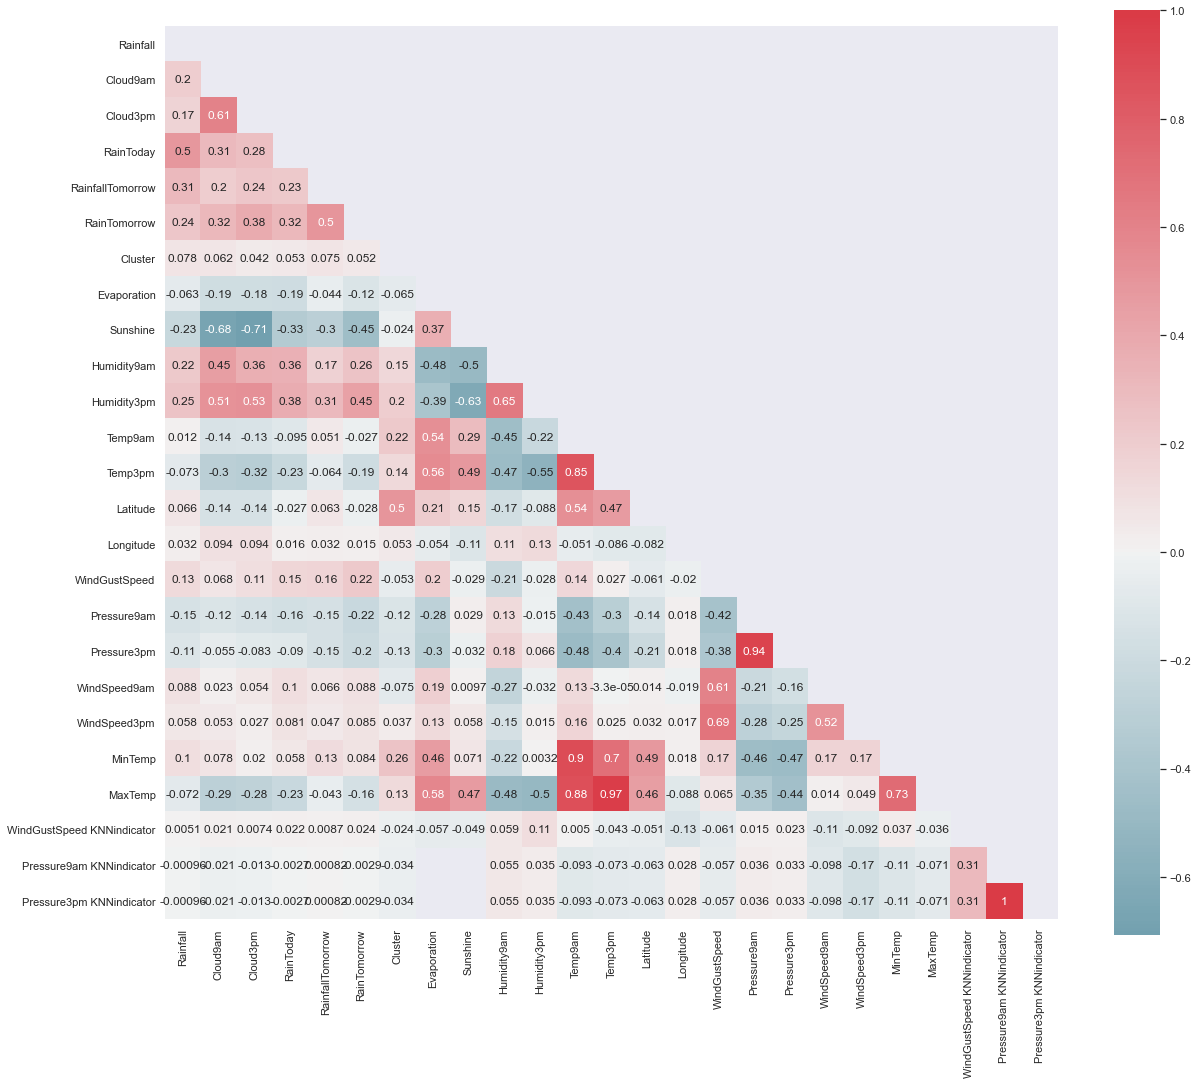

In [61]:
plot_corrMatrix(data_custom_transformed, method = 'pearson')

# Dirección del viento: Imputación de datos faltantes y codificación de variables

Para trabajar con las variables de dirección del viento primero le asigno un valor numérico de 0 a 15 para poder realizar una imputación por KNN. El valor resultante de la imputación va a ser redondeado para que quede dentro de la etiqueta más cercana. Luego los valores numéricos van a ser codificados utilizando codificación cíclica con sin() cos()

In [62]:
coord_to_num = {
    "E": 0, "ENE": 1, "NE": 2, "NNE": 3, 
    "N": 4, "NNW": 5, "NW": 6, "WNW": 7, 
    "W": 8, "WSW": 9, "SW": 10, "SSW": 11,
    "S": 12, "SSE": 13, "SE": 14, "ESE": 15,
}
data_custom_transformed.replace(coord_to_num, inplace = True)

In [63]:
# Imputación por KNN
vars_to_KNN = ['WindGustDir', 'WindDir9am', 'WindDir3pm'] # Defino variables a imputar

imputer = KNNImputer(missing_values=np.nan, add_indicator=True, n_neighbors = 5) # Defino estimador
data_imputed_KNN = imputer.fit_transform(data_custom_transformed[vars_to_KNN]) # Entreno el estimador con las columnas de dirección del viento
aux = vars_to_KNN.copy()
for i in aux:
    vars_to_KNN.append(i + ' KNNindicator')
data_imputed_KNN = pd.DataFrame(data_imputed_KNN, columns = vars_to_KNN)
data_imputed_KNN = data_imputed_KNN.round(0) # Redondeo al valor más cercano
data_custom_transformed.drop(columns = aux, inplace = True) # Elimino columnas originales que fueron imputadas con KNN
data_custom_transformed[vars_to_KNN] = data_imputed_KNN.values # Agrego las nuevas columnas al data set

In [64]:
# Codificación de variables circulares
dir_colums = ['WindGustDir','WindDir9am','WindDir3pm']
for col in dir_colums:
    data_custom_transformed[col + '_cos'] = np.cos(2 * np.pi * (data_custom_transformed[col] / 16))
    data_custom_transformed[col + '_sin'] = np.sin(2 * np.pi * (data_custom_transformed[col] / 16))
data_custom_transformed.drop(columns = dir_colums, inplace = True)

# Sunshine, Evaporation and clouds: Imputación de datos 

Debido a que la cantidad de datos faltantes es muy importante en estas variables elijo por eliminar las features en una primera prueba

In [65]:
data_custom_transformed.drop(columns = ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'], inplace = True)

In [66]:
data_custom_transformed.isna().sum()

Location                      0
Date                          0
Rainfall                      0
RainToday                     0
RainfallTomorrow              0
RainTomorrow                  0
Cluster                       0
Humidity9am                   0
Humidity3pm                   0
Temp9am                       0
Temp3pm                       0
Latitude                      0
Longitude                     0
WindGustSpeed                 0
Pressure9am                   0
Pressure3pm                   0
WindSpeed9am                  0
WindSpeed3pm                  0
MinTemp                       0
MaxTemp                       0
WindGustSpeed KNNindicator    0
Pressure9am KNNindicator      0
Pressure3pm KNNindicator      0
WindGustDir KNNindicator      0
WindDir9am KNNindicator       0
WindDir3pm KNNindicator       0
WindGustDir_cos               0
WindGustDir_sin               0
WindDir9am_cos                0
WindDir9am_sin                0
WindDir3pm_cos                0
WindDir3

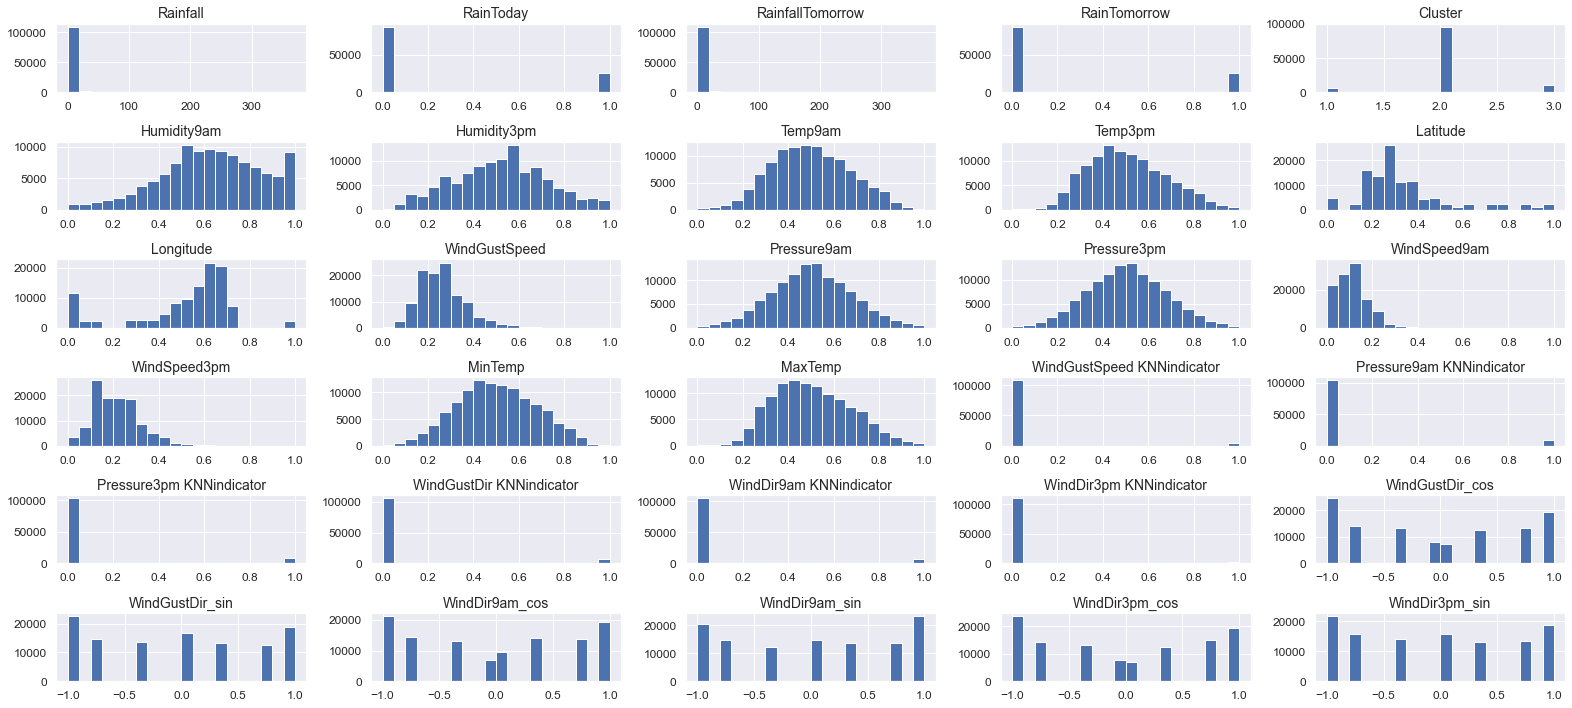

In [67]:
display_dataset_distributions(data_custom_transformed)

C:\Users\alexb\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Humidity3pm', ylabel='Humidity9am'>

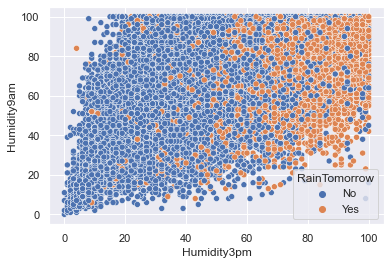

In [68]:
sns.scatterplot(all_data['Humidity3pm'], all_data['Humidity9am'], hue=all_data['RainTomorrow'])

C:\Users\alexb\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='MinTemp', ylabel='MaxTemp'>

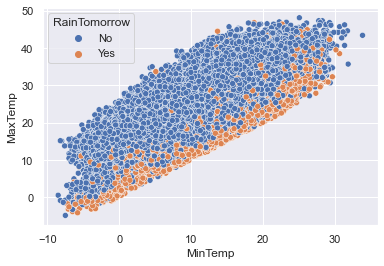

In [69]:
sns.scatterplot(all_data['MinTemp'], all_data['MaxTemp'], hue=all_data['RainTomorrow'])

C:\Users\alexb\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Humidity3pm', ylabel='Humidity9am'>

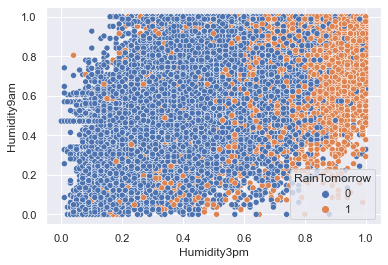

In [70]:
sns.scatterplot(data_custom_transformed['Humidity3pm'], data_custom_transformed['Humidity9am'], hue=data_custom_transformed['RainTomorrow'])

C:\Users\alexb\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='MinTemp', ylabel='MaxTemp'>

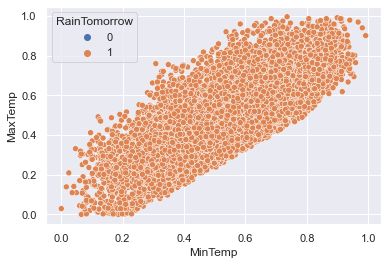

In [71]:
sns.scatterplot(data[data['RainTomorrow'] == 1]['MinTemp'], data[data['RainTomorrow'] == 1]['MaxTemp'], hue=data['RainTomorrow'])

C:\Users\alexb\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='MinTemp', ylabel='MaxTemp'>

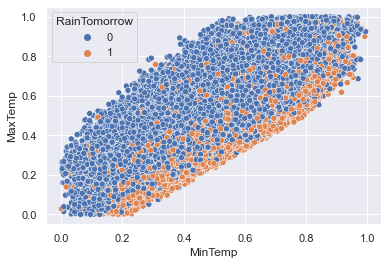

In [72]:
sns.scatterplot(data['MinTemp'], data['MaxTemp'], hue=data['RainTomorrow'])

C:\Users\alexb\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='MinTemp', ylabel='MaxTemp'>

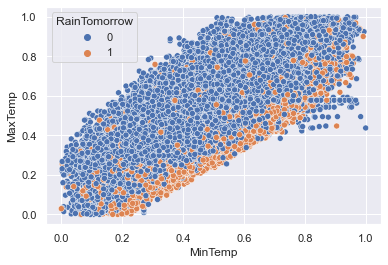

In [73]:
sns.scatterplot(data_custom_transformed['MinTemp'], data_custom_transformed['MaxTemp'], hue=data_custom_transformed['RainTomorrow'])

C:\Users\alexb\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='RainfallTomorrow', ylabel='Humidity9am'>

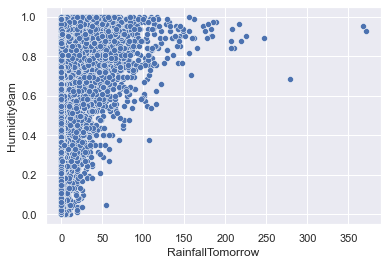

In [74]:
sns.scatterplot(data_custom_transformed['RainfallTomorrow'], data_custom_transformed['Humidity9am'])

In [75]:
data['RainTomorrow'].sum()

25046

In [76]:
data_custom_transformed['RainTomorrow'].sum()

25046

In [77]:
def make_mi_scores(X, y, discrete_features = 'auto'):
    from sklearn.feature_selection import mutual_info_regression
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    mi_scores = mi_scores.sort_values(ascending=True)
    width = np.arange(len(mi_scores))
    ticks = list(mi_scores.index)
    plt.figure(dpi=100, figsize=(12, 7))
    plt.barh(width, mi_scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

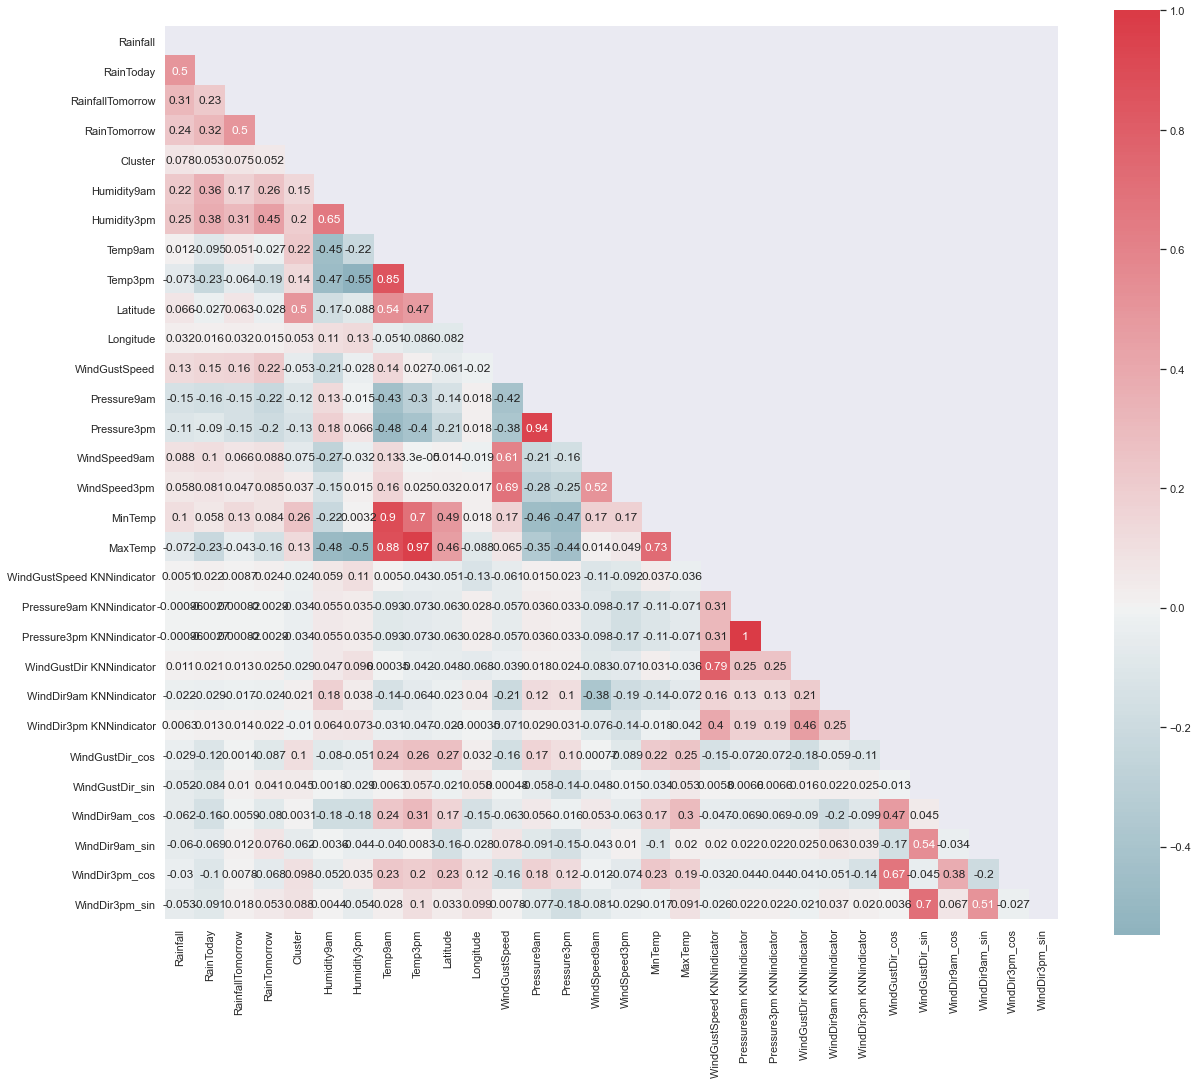

In [78]:
plot_corrMatrix(data_custom_transformed, method = 'pearson')

C:\Users\alexb\anaconda3\lib\site-packages\scipy\stats\stats.py:4594: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


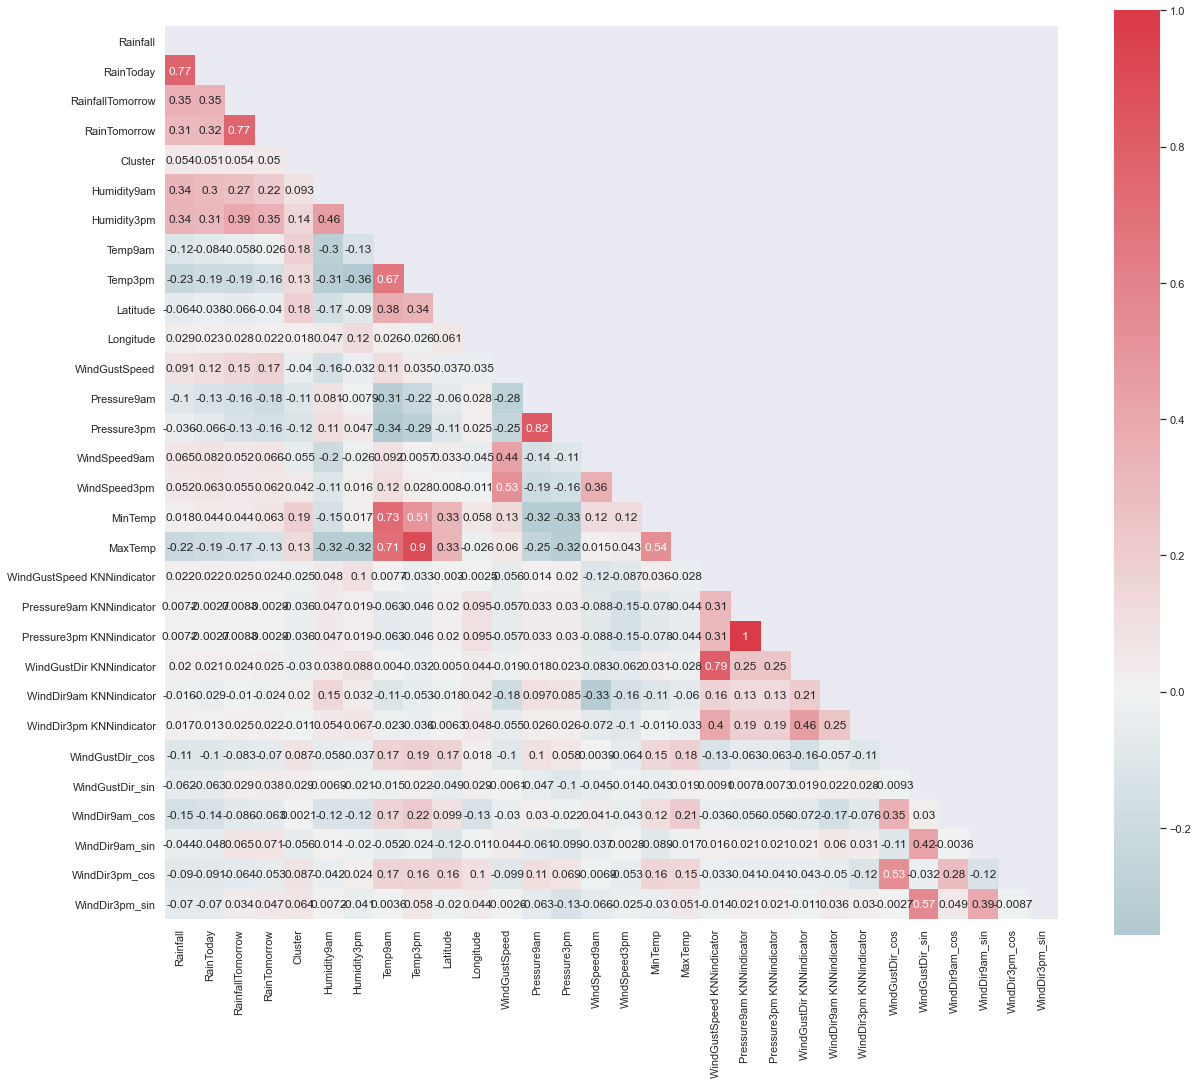

In [79]:
plot_corrMatrix(data_custom_transformed, method = 'kendall')

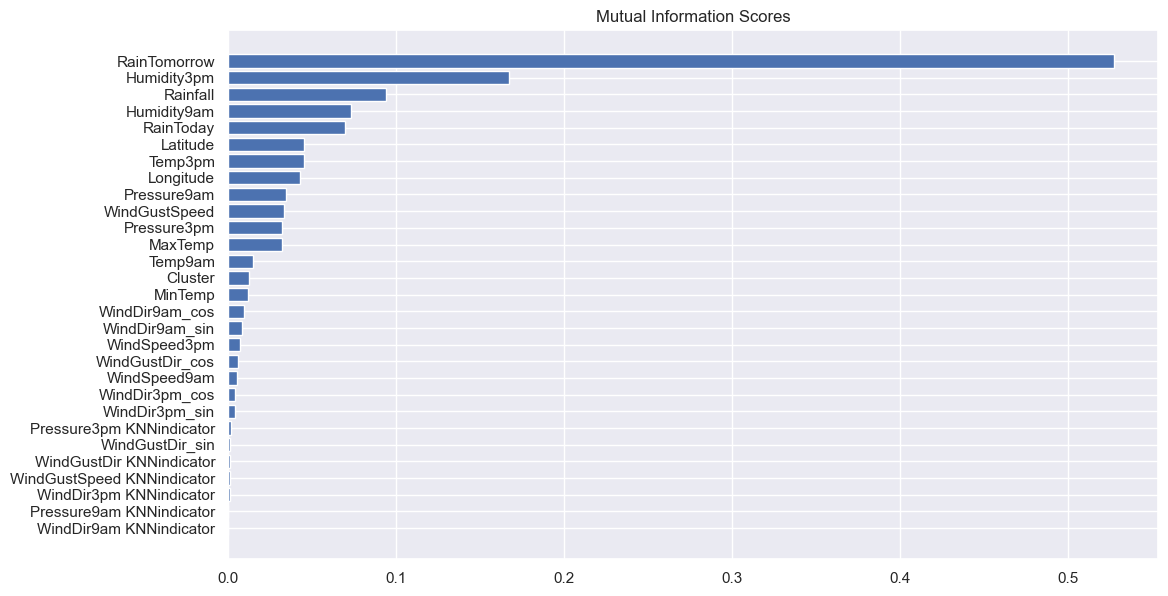

In [80]:
make_mi_scores(data_custom_transformed.drop(columns = ['RainfallTomorrow', 'Location', 'Date']), data_custom_transformed['RainfallTomorrow'])

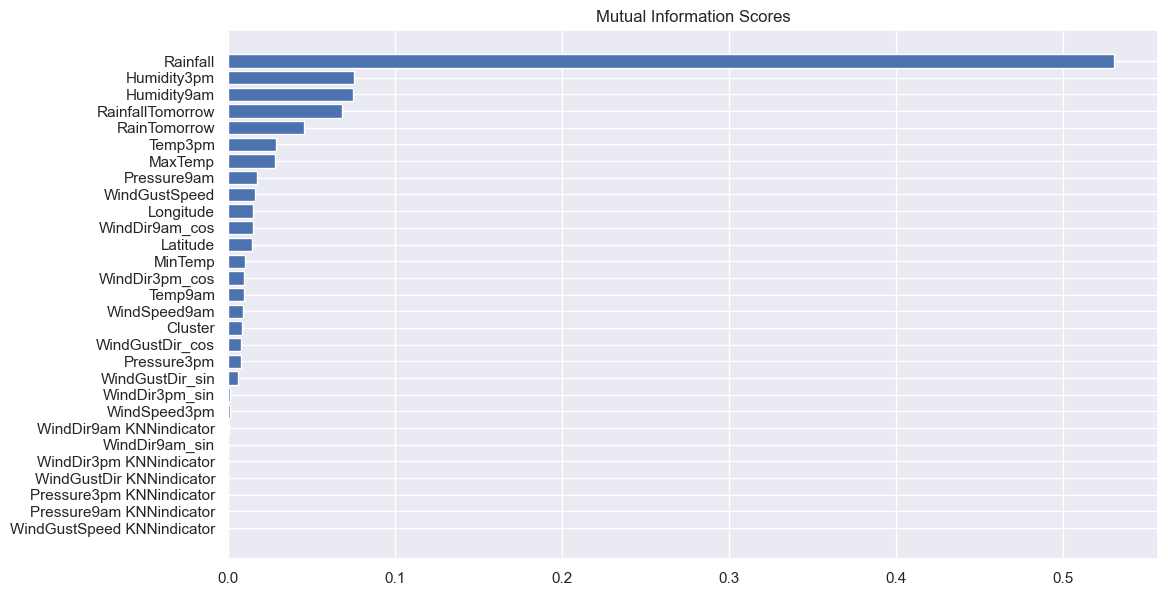

In [81]:
make_mi_scores(data_custom_transformed.drop(columns = ['RainToday', 'Location', 'Date']), data_custom_transformed['RainToday'])

## Transformaciones: Normalización y codificación de variables categóricas

Para una primera prueba elimino las variables *Evaporation*, *Sunshine*, *Cloud9am* y *Cloud3pm* por la gran cantidad de datos faltantes. Si luego me falta información para el modelo, vuelvo a implementar alguna otra técnica de imputación.

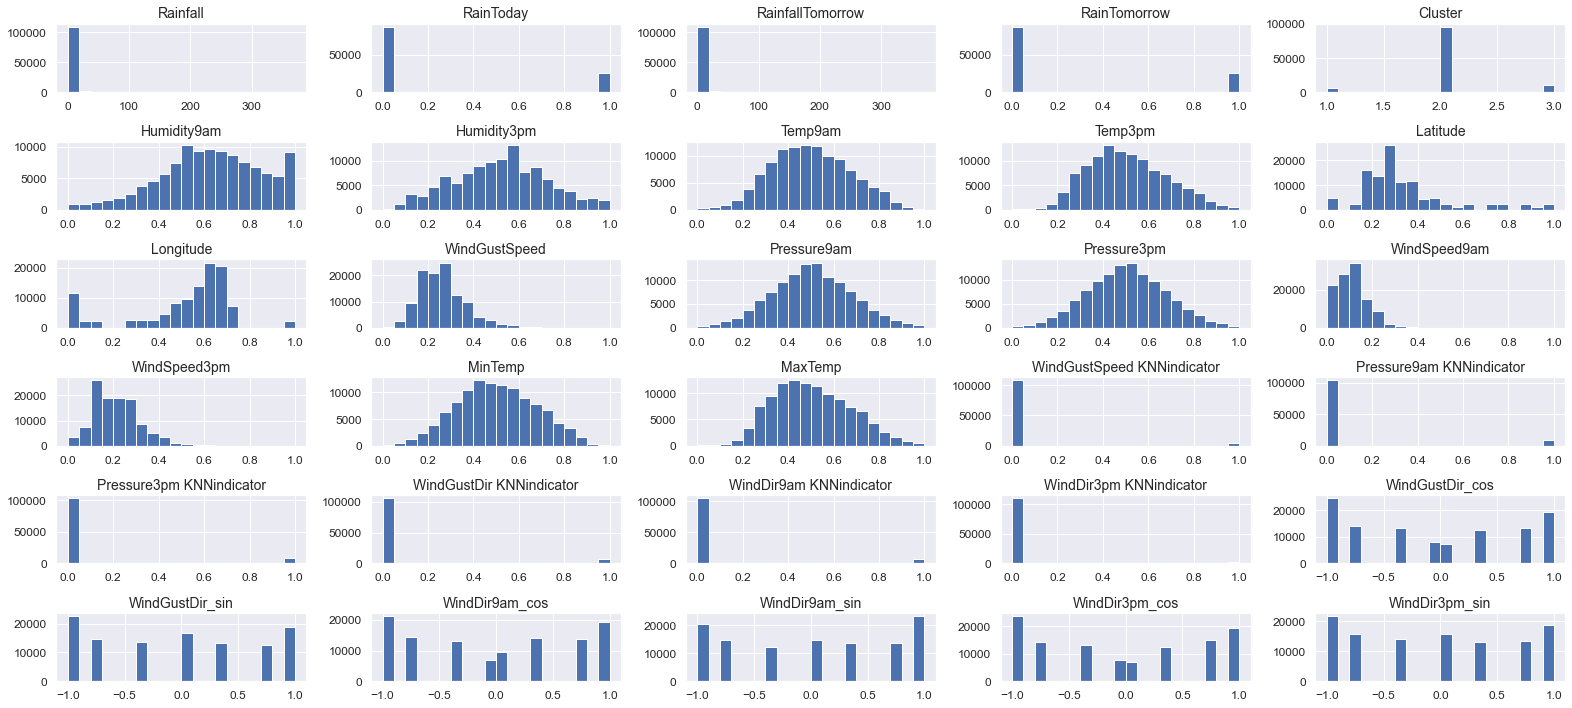

In [82]:
display_dataset_distributions(data_custom_transformed)

In [83]:
vars_to_norm = ['Humidity9am', 'Humidity3pm', 'Temp9am', 'Temp3pm', 'WindGustSpeed', 'Pressure9am', 'Pressure3pm', 'WindSpeed9am', 'WindSpeed3pm', 'MinTemp', 'MaxTemp']

In [84]:
data_custom_transformed[vars_to_norm]

Humidity9am  Humidity3pm   Temp9am   Temp3pm  WindGustSpeed  \
0          0.292683         0.45  0.636119  0.633333       0.310078   
1          0.414634         0.55  0.390836  0.346154       0.155039   
2          0.519815         0.05  0.711590  0.784615       0.310078   
3          0.256098         0.26  0.512129  0.520513       0.209302   
4          0.731707         0.69  0.547170  0.461538       0.286822   
...             ...          ...       ...       ...            ...   
112591     0.463415         0.21  0.371968  0.464103       0.186047   
112592     0.548780         0.30  0.619946  0.735897       0.286822   
112593     0.719512         0.27  0.711590  0.820513       0.155039   
112594     0.268293         0.18  0.649596  0.723077       0.356589   
112595     0.060976         0.09  0.584906  0.617949       0.209302   

        Pressure9am  Pressure3pm  WindSpeed9am  WindSpeed3pm   MinTemp  \
0          0.354667     0.456464      0.015385      0.275862  0.640327   
1          0.549333     0.564644      0.069231      0.080460  0.411444   
2          0.541333     0.451187      0.169231      0.252874  0.599455   
3          0.885333     0.854881      0.084615      0.218391  0.457766   
4          0.154667     0.242744      0.100000      0.229885  0.629428   
...             ...          ...           ...           ...       ...   
112591     0.597333     0.591029      0.184615      0.149425  0.365123   
112592     0.493333     0.503958      0.153846      0.195402  0.662125   
112593     0.376000     0.398417      0.115385      0.126437  0.760218   
112594     0.546667     0.511873      0.238462      0.229885  0.618529   
112595     0.661333     0.633245      0.100000      0.218391  0.438692   

         MaxTemp  
0       0.610706  
1       0.335766  
2       0.759124  
3       0.493917  
4       0.467153  
...          ...  
112591  0.464720  
112592  0.737226  
112593  0.807786  
112594  0.705596  
112595  0.600973  

[112596 rows x 11 columns]

In [85]:
from sklearn.preprocessing import QuantileTransformer

quantile = QuantileTransformer(output_distribution= 'normal')

In [86]:
aux_data_nomalized = quantile.fit_transform(data_custom_transformed[vars_to_norm])
data_norm = data_custom_transformed.drop(columns = vars_to_norm)
data_norm[vars_to_norm] = aux_data_nomalized

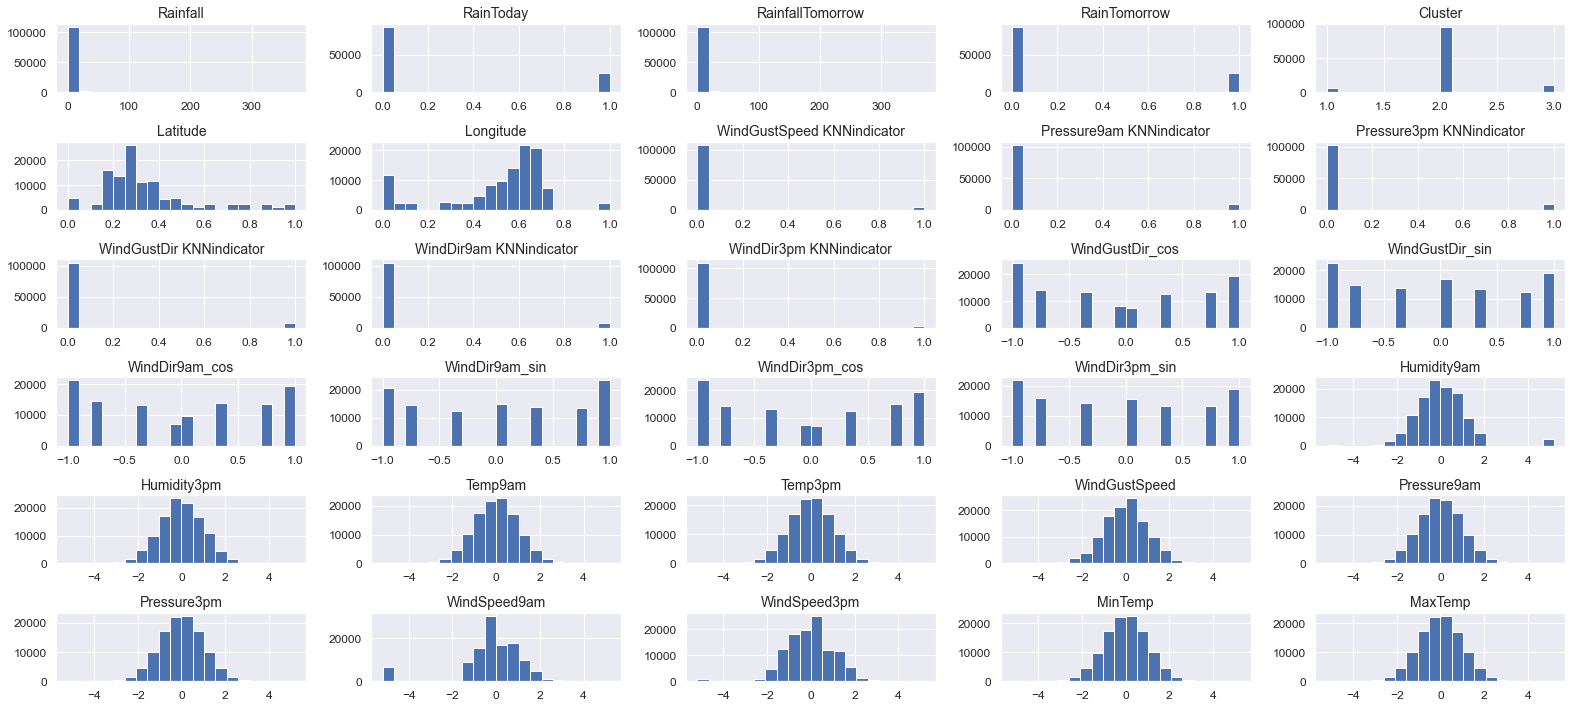

In [87]:
display_dataset_distributions(data_norm)

# Análisis de correlación y CIM

In [88]:
def make_corr_scores2(X, y):
    import scipy.stats
    corr_scores = []
    corr_scores = np.array(corr_scores)
    for i in X.columns:
        # print(corr_scores,np.corrcoef(X[i], y)[0,1])
        corr_scores = np.append(corr_scores,abs(np.corrcoef(X[i], y)[0,1]))
    corr_scores = pd.Series(corr_scores, name="MI Scores", index=X.columns)
    corr_scores = corr_scores.sort_values(ascending = True)
    width1 = np.arange(len(corr_scores))
    ticks = list(corr_scores.index)
    
    corr_scores2 = []
    corr_scores2 = np.array(corr_scores2)
    for i in X.columns:
        # print(corr_scores,np.corrcoef(X[i], y)[0,1])
        corr_scores2 = np.append(corr_scores2,abs(scipy.stats.spearmanr(X[i], y)[0]))
    corr_scores2 = pd.Series(corr_scores2, name="MI Scores", index=X.columns)
    corr_scores2 = corr_scores2.sort_values(ascending = True)
    width2 = np.arange(len(corr_scores2))
    ticks = list(corr_scores2.index)
    
    corr_scores3 = []
    corr_scores3 = np.array(corr_scores3)
    for i in X.columns:
        # print(corr_scores,np.corrcoef(X[i], y)[0,1])
        corr_scores3 = np.append(corr_scores3,abs(scipy.stats.kendalltau(X[i], y)[0]))
    corr_scores3 = pd.Series(corr_scores3, name = "MI Scores", index = X.columns)
    corr_scores3 = corr_scores3.sort_values(ascending = True)
    width3 = np.arange(len(corr_scores3))
    ticks = list(corr_scores3.index)
    
    
    plt.figure(dpi=100, figsize=(17, 10))
    plt.barh(width1, corr_scores, label = 'Pearson R', height = 0.3)
    plt.barh(width2+0.3, corr_scores2,  label = 'Spearman Rho', height = 0.3)
    plt.barh(width3+0.6, corr_scores3, label = 'Kendall Tau', height = 0.3)
    plt.yticks(width1, ticks)
    plt.title("CORRELATION SCORES")
    plt.legend()
    
#     print(corr_scores)
#     return pd.DataFrame([X.columns, corr_scores.T])

In [89]:
# Creo nuevas features
data_norm['TempAmplitude'] = data_norm.Temp3pm - data_norm.Temp9am
data_norm['PressureAmplitude'] = data_norm.Pressure3pm - data_norm.Pressure9am
data_norm['HumidityAmplitude'] = data_norm.Humidity3pm - data_norm.Humidity9am
data_norm['HumidityWindGustSpeed'] = data_norm.HumidityAmplitude * data_norm.WindGustSpeed


In [90]:
data_norm.max()

Location                         Woomera
Date                          2017-06-24
Rainfall                           371.0
RainToday                              1
RainfallTomorrow                   371.0
RainTomorrow                           1
Cluster                              3.0
Latitude                             1.0
Longitude                            1.0
WindGustSpeed KNNindicator           1.0
Pressure9am KNNindicator             1.0
Pressure3pm KNNindicator             1.0
WindGustDir KNNindicator             1.0
WindDir9am KNNindicator              1.0
WindDir3pm KNNindicator              1.0
WindGustDir_cos                      1.0
WindGustDir_sin                      1.0
WindDir9am_cos                       1.0
WindDir9am_sin                       1.0
WindDir3pm_cos                       1.0
WindDir3pm_sin                       1.0
Humidity9am                     5.199338
Humidity3pm                     5.199338
Temp9am                         5.199338
Temp3pm         

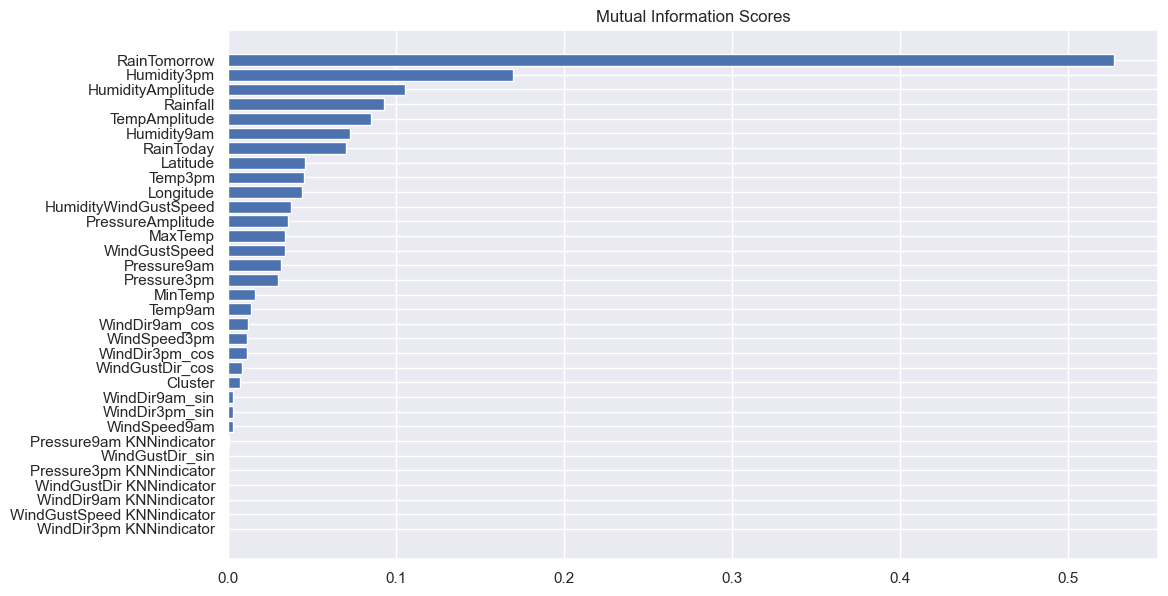

In [91]:
# Criterio de la información mutua para RainfallTomorrow
make_mi_scores(data_norm.drop(columns = ['RainfallTomorrow', 'Location', 'Date']), data_norm['RainfallTomorrow'])

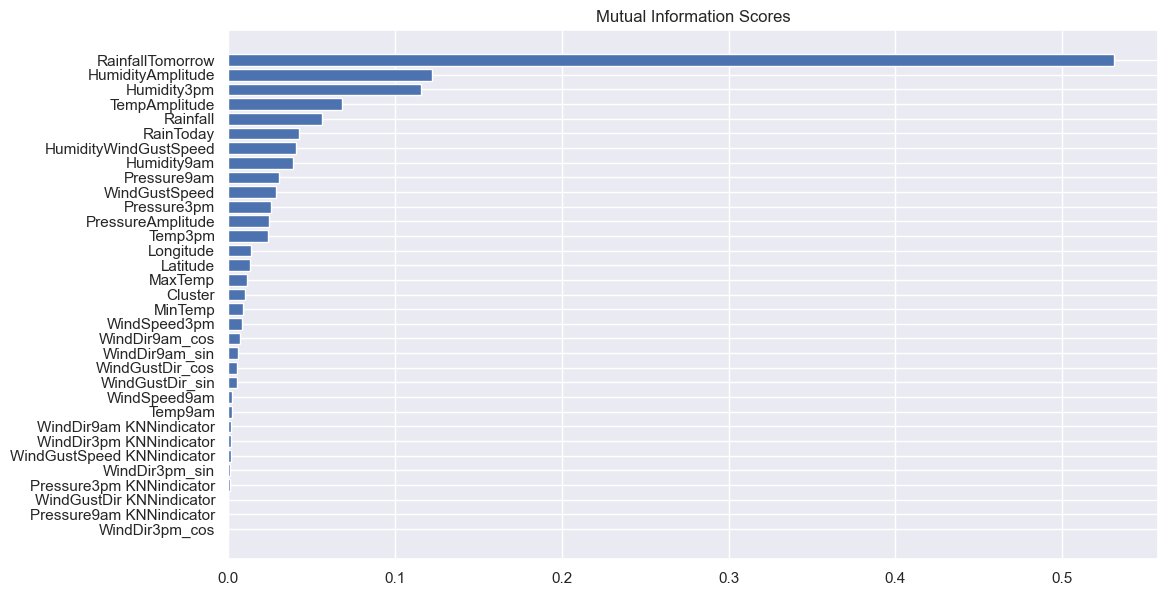

In [92]:
# Criterio de la información mutua para RainTomorrow
make_mi_scores(data_norm.drop(columns = ['RainTomorrow', 'Location', 'Date']), data_norm['RainTomorrow'])

C:\Users\alexb\anaconda3\lib\site-packages\scipy\stats\stats.py:4594: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


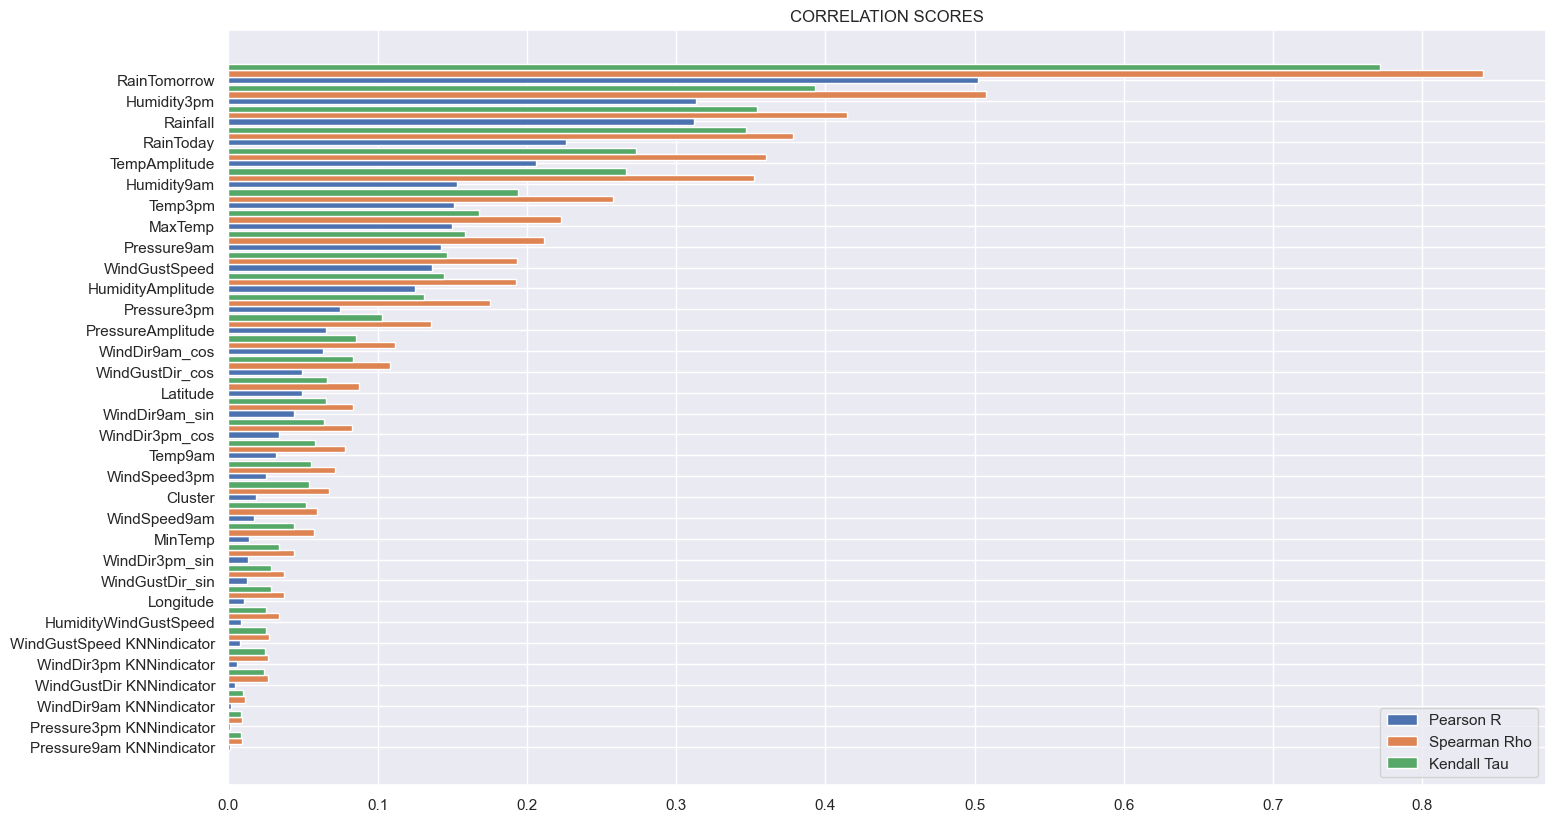

In [93]:
# Correlaciones para RainfallTomorrow
make_corr_scores2(data_norm.drop(columns = ['RainfallTomorrow', 'Location', 'Date']), data_norm['RainfallTomorrow'])

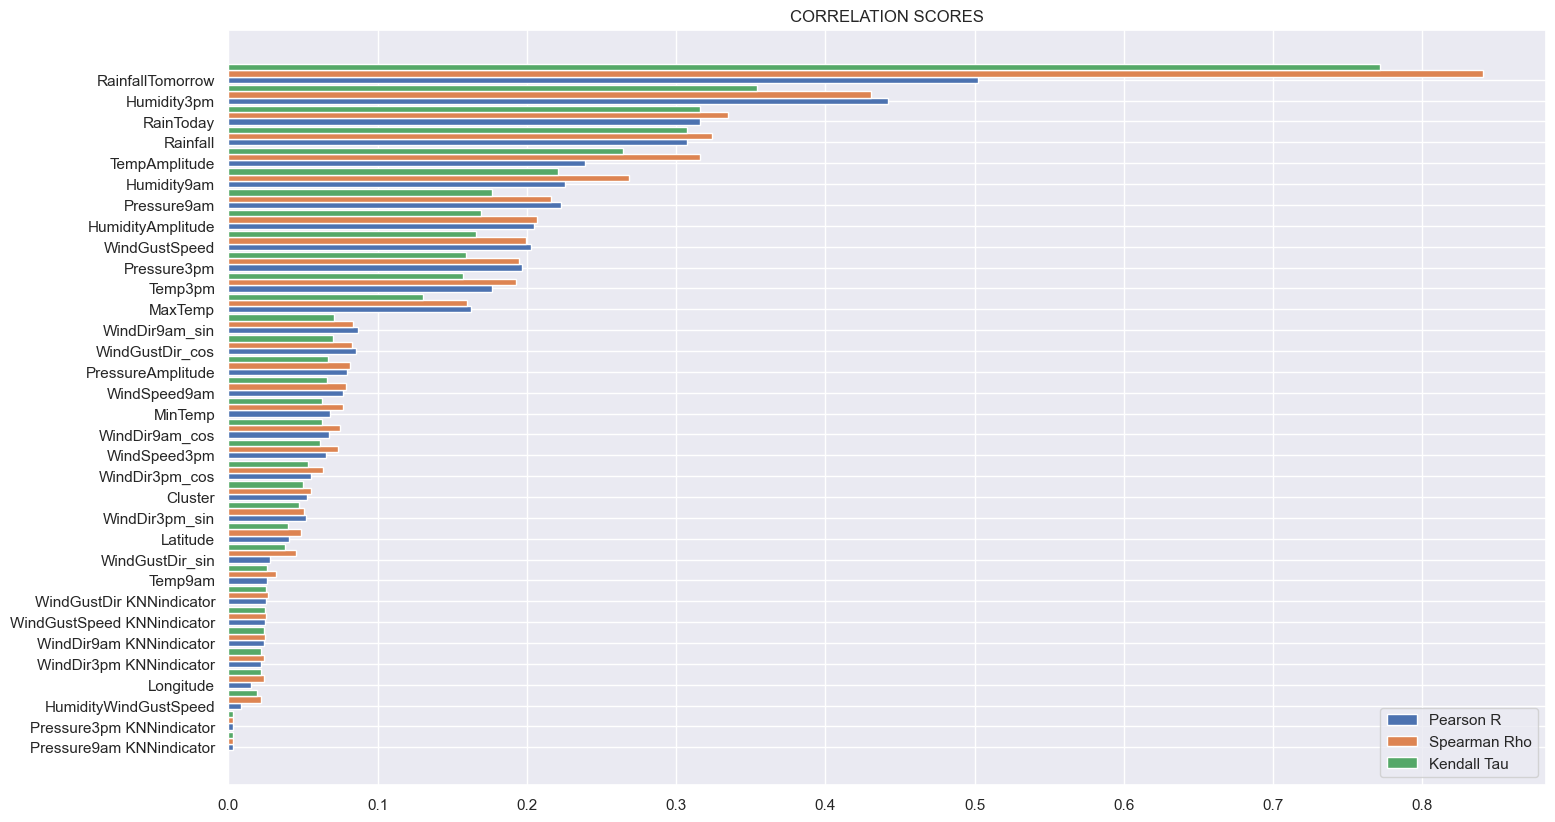

In [94]:
# Correlaciones para RainTomorrow
make_corr_scores2(data_norm.drop(columns = ['RainTomorrow', 'Location', 'Date']), data_norm['RainTomorrow'])

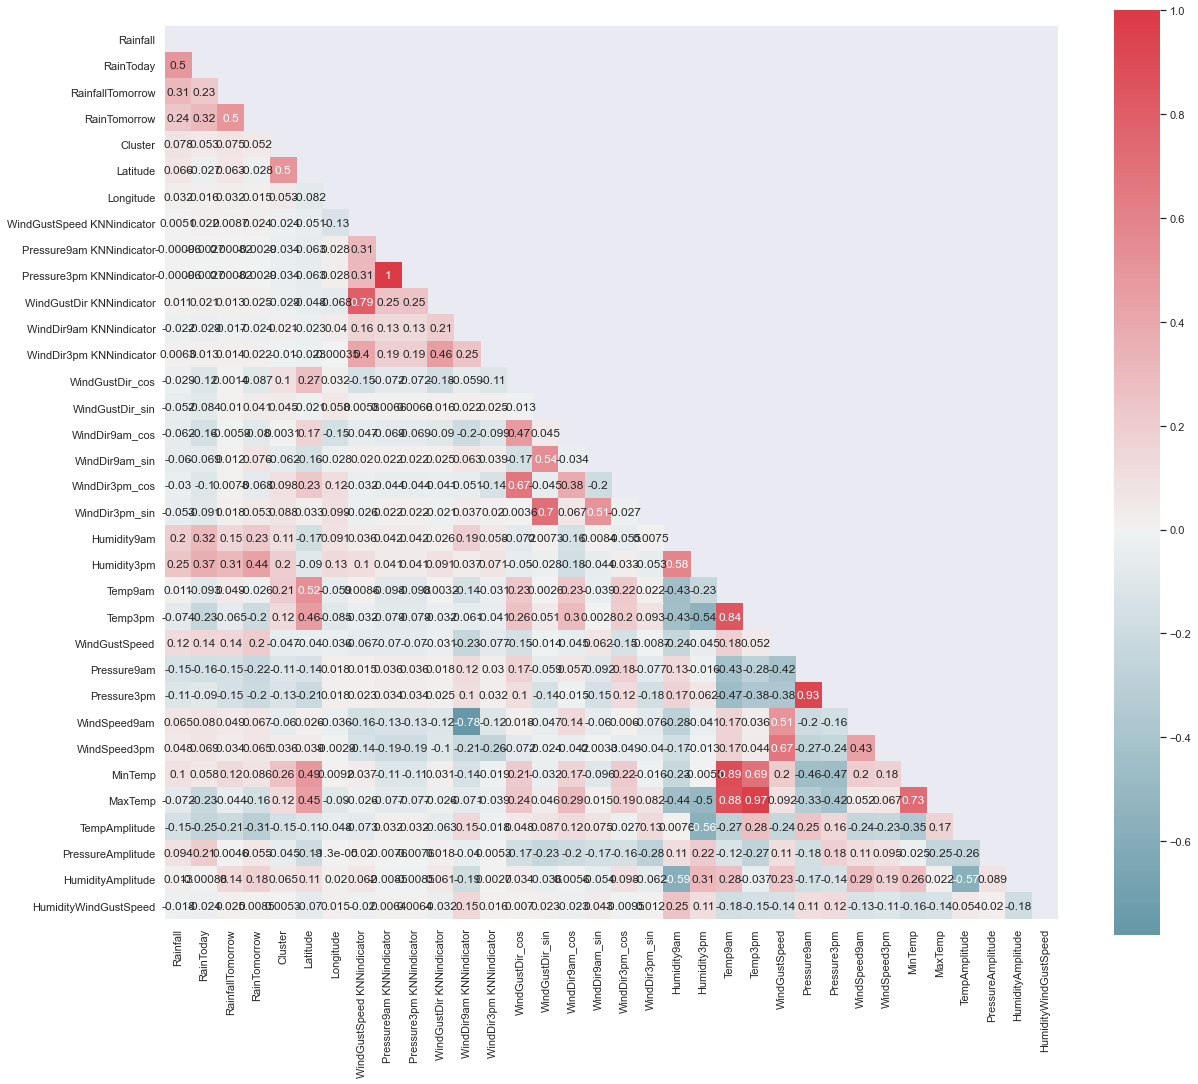

In [95]:
plot_corrMatrix(data_norm, method = 'pearson')

Descarto Pressure3pm ya que está altamente correlacionada con Pressure9am y el CIM es mayor en esta última.

Descarto MinTemp y MaxTemp ya que estan altamente correlacionadas con Temp9am y Temp3pm y el CIM es mayor en estas últimas.

Descarto Humidity9am ya que está correlacionada con Humidity3pm y HumidityAmplitude

In [101]:
regression_var_discard = ['Humidity9am', 'MinTemp', 'MaxTemp', 'Pressure3pm', 'Date', 'Location']

In [102]:
regression_dataset = data_norm.drop(columns = regression_var_discard)

In [103]:
regression_dataset.head()

Rainfall  RainToday  RainfallTomorrow  RainTomorrow  Cluster  Latitude  \
0       0.0          0               0.0             0      2.0  0.261466   
1       0.0          0               1.2             1      2.0  0.261466   
2       0.0          0               0.0             0      2.0  0.261466   
3       0.0          0               0.0             0      2.0  0.261466   
4       1.4          1               7.2             1      2.0  0.261466   

   Longitude  WindGustSpeed KNNindicator  Pressure9am KNNindicator  \
0   0.444575                         0.0                       0.0   
1   0.444575                         0.0                       0.0   
2   0.444575                         0.0                       0.0   
3   0.444575                         0.0                       0.0   
4   0.444575                         0.0                       0.0   

   Pressure3pm KNNindicator  WindGustDir KNNindicator  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   WindDir9am KNNindicator  WindDir3pm KNNindicator  WindGustDir_cos  \
0                      0.0                      0.0    -7.071068e-01   
1                      0.0                      0.0     3.826834e-01   
2                      0.0                      0.0     6.123234e-17   
3                      0.0                      0.0    -9.238795e-01   
4                      0.0                      0.0    -9.238795e-01   

   WindGustDir_sin  WindDir9am_cos  WindDir9am_sin  WindDir3pm_cos  \
0        -0.707107    6.123234e-17        1.000000   -7.071068e-01   
1         0.923880    7.071068e-01        0.707107    7.071068e-01   
2         1.000000    7.071068e-01        0.707107    6.123234e-17   
3         0.382683    3.826834e-01        0.923880   -7.071068e-01   
4        -0.382683   -7.071068e-01        0.707107   -9.238795e-01   

   WindDir3pm_sin  Humidity3pm   Temp9am   Temp3pm  WindGustSpeed  \
0       -0.707107    -0.320290  0.738089  0.711981       0.610484   
1        0.707107     0.134645 -0.568686 -0.864365      -1.144896   
2        1.000000    -2.877846  1.135284  1.479004       0.610484   
3        0.707107    -1.157061  0.104318  0.161281      -0.430727   
4       -0.382683     0.849874  0.288750 -0.153660       0.374936   

   Pressure9am  WindSpeed9am  WindSpeed3pm  TempAmplitude  PressureAmplitude  \
0    -0.839121     -1.428482      0.687939      -0.026108           0.558210   
1     0.293986     -0.459820     -1.425011      -0.295680           0.068865   
2     0.249721      0.965420      0.506348       0.343720          -0.559464   
3     2.144011     -0.221344      0.101796       0.056963          -0.167067   
4    -1.976943     -0.002509      0.309743      -0.442410           0.459398   

   HumidityAmplitude  HumidityWindGustSpeed  
0           1.101266               0.672305  
1           1.080261              -1.236786  
2          -2.371498              -1.447761  
3           0.388866              -0.167495  
4           0.426019               0.159730

# Feature Selection

In [519]:
# Separo en X e y
X = regression_dataset.drop(columns = 'RainfallTomorrow')
y = regression_dataset.RainfallTomorrow

In [520]:
# SELECCIÓN DE FEATURES PARA REGRESIÓN
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE
rfe_selector = RFE(estimator = GradientBoostingRegressor(), n_features_to_select = 20, step = 1) # step es la cantidad de features que se descartan por iteración

In [521]:
rfe_selector.fit(X, y)

RFE(estimator=GradientBoostingRegressor(), n_features_to_select=20)

In [522]:
X.columns[rfe_selector.get_support()]

Index(['Rainfall', 'RainTomorrow', 'Latitude', 'Longitude', 'WindGustDir_cos',
       'WindGustDir_sin', 'WindDir9am_cos', 'WindDir3pm_cos', 'WindDir3pm_sin',
       'Humidity3pm', 'Temp9am', 'Temp3pm', 'WindGustSpeed', 'Pressure9am',
       'WindSpeed9am', 'WindSpeed3pm', 'TempAmplitude', 'PressureAmplitude',
       'HumidityAmplitude', 'HumidityWindGustSpeed'],
      dtype='object')

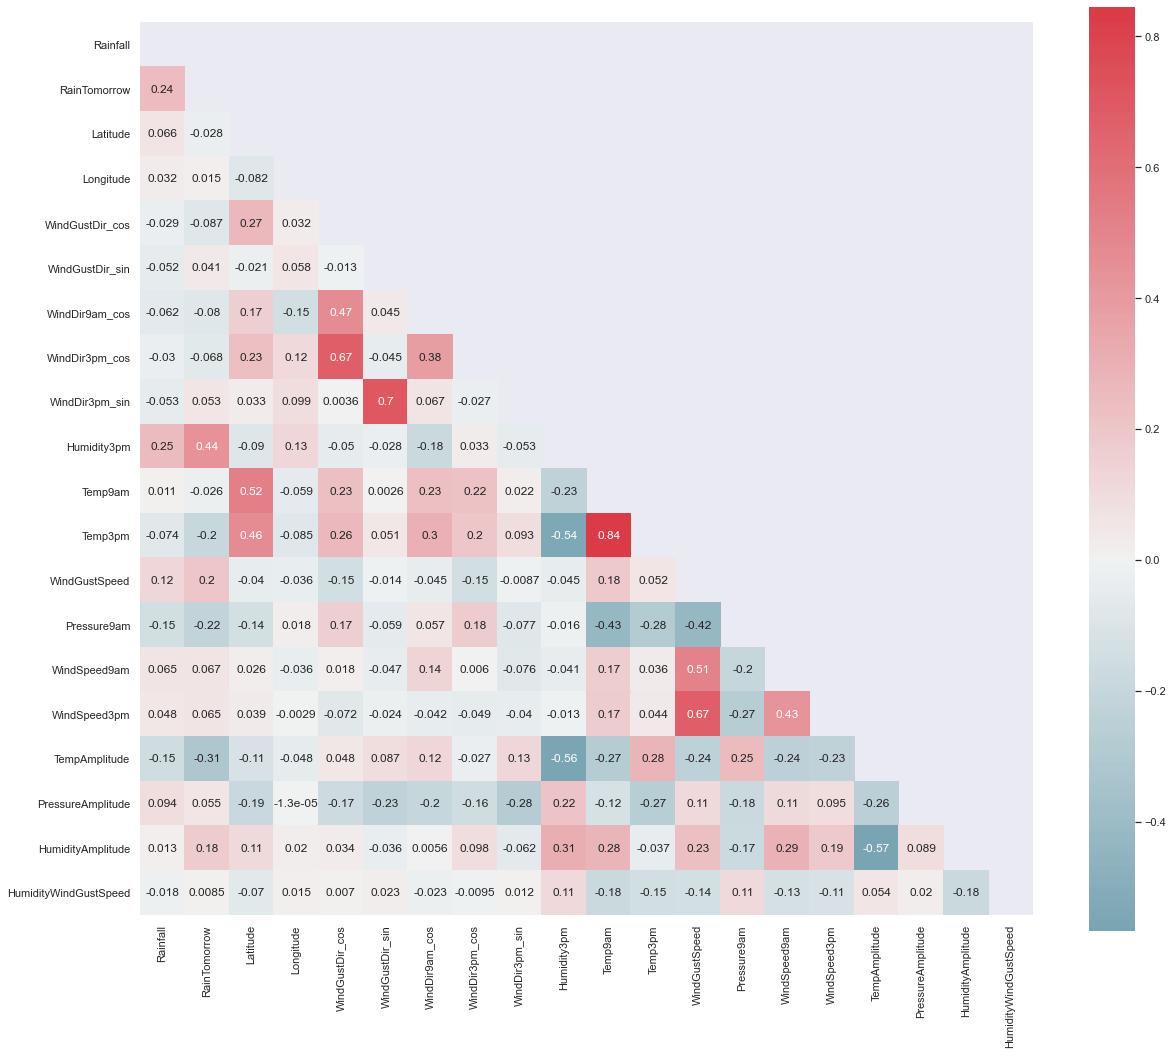

In [112]:
plot_corrMatrix(regression_dataset[X.columns[rfe_selector.get_support()]], method = 'pearson')

In [113]:
# Separo en X e y
X = regression_dataset.drop(columns = 'RainTomorrow')
y = regression_dataset.RainTomorrow

In [114]:
# SELECCIÓN DE FEATURES PARA CLASIFICACIÓN
from sklearn.ensemble import GradientBoostingClassifier
rfe_selector_clas = RFE(estimator = GradientBoostingClassifier(), n_features_to_select = 20, step = 1) # step es la cantidad de features que se descartan por iteración

In [115]:
rfe_selector_clas.fit(X, y)

RFE(estimator=GradientBoostingClassifier(), n_features_to_select=20)

In [116]:
X.columns[rfe_selector_clas.get_support()]

Index(['RainfallTomorrow', 'Cluster', 'Latitude', 'Longitude',
       'WindGustSpeed KNNindicator', 'Pressure9am KNNindicator',
       'Pressure3pm KNNindicator', 'WindGustDir KNNindicator',
       'WindDir3pm KNNindicator', 'Humidity3pm', 'Temp9am', 'Temp3pm',
       'WindGustSpeed', 'Pressure9am', 'WindSpeed9am', 'WindSpeed3pm',
       'TempAmplitude', 'PressureAmplitude', 'HumidityAmplitude',
       'HumidityWindGustSpeed'],
      dtype='object')

# PROCESAMIENTO DE LOS DATOS DEL TRAIN Y TEST SET CON PIPELINE

In [117]:
test_data = pd.concat([X_test, y_test], axis=1)

In [119]:
test_data.head()

Date      Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
117947  2009-11-15  PerthAirport      9.4     27.6       0.0          6.2   
8803    2016-10-14         Cobar      7.0     23.2       0.0          NaN   
113057  2013-03-16   Witchcliffe     16.9     25.3       0.0          NaN   
61609   2010-03-04          Sale     11.7     31.8       0.0          4.6   
60633   2015-12-25       Bendigo     19.0     34.7       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
117947      10.9         WSW           37.0          W        WSW   
8803         NaN         ENE           33.0        ENE          E   
113057       NaN          SE           52.0        ESE        ESE   
61609        5.6         ESE           31.0         NW          E   
60633        NaN         NNE           52.0         NE        NNE   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
117947           9.0          26.0         49.0         44.0       1014.3   
8803            20.0          15.0          NaN          NaN       1023.3   
113057          19.0          20.0         71.0         57.0       1022.1   
61609            9.0          17.0         97.0         33.0       1012.9   
60633           26.0          31.0         42.0         22.0       1012.3   

        Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm RainToday  \
117947       1010.8       1.0       1.0     23.1     25.8        No   
8803         1020.4       NaN       NaN     14.9     21.4        No   
113057       1019.4       NaN       NaN     19.4     24.5        No   
61609        1009.5       6.0       6.0     14.7     30.5        No   
60633        1006.4       NaN       NaN     23.3     32.7        No   

        RainfallTomorrow RainTomorrow  
117947               0.0           No  
8803                 0.0           No  
113057               0.0           No  
61609                0.0           No  
60633                7.6          Yes

# 1) CODIFICO VARIABLES BINARIAS

In [287]:
class BinaryEncoding(BaseEstimator, TransformerMixin):
    def fit(self, target):
        print('\n BinaryEncodig() fit called.\n')
        return self
    
    def transform(self, target):
        print('\n BinaryEncodig() transform called.\n')
        target_ = target.copy()
        target_.replace(('Yes', 'No'), (1, 0), inplace = True)
        return target_

# 2) DETECTO OUTLIERS

In [288]:
class OutliersDetection(BaseEstimator, TransformerMixin):
    def fit(self, data, parameters = None):
        print('\n OutliersDetection() fit called.\n')
        labels = ['MinTemp', 'MaxTemp', 'Humidity9am', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']
        # Defino matriz donde almaceno los límites superiores e inferiores para cada OL
        self.OL_matrix = pd.DataFrame(index = labels, columns = ['Lower', 'Upper']) 

        for i in labels:
            q25 = data[i].quantile(0.25)
            q75 = data[i].quantile(0.75) 
            iqr = q75 - q25 # Calculo el rango intercuartílico
            cutoff = iqr * 1.5 # Valor a partir del cual considero un outlier
            self.OL_matrix.loc[i, 'Lower'] = q25 - cutoff # Límite inferior
            self.OL_matrix.loc[i, 'Upper'] = q75 + cutoff # Límite superior
        return self
    
    def transform(self, data):
        print('\n OutliersDetection() transform called.\n')
        data_ = data.copy()
        replace = np.NaN
        labels = ['MinTemp', 'MaxTemp', 'Humidity9am', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']
        for i in labels:
            data_.loc[((data_[i] < self.OL_matrix.loc[i, 'Lower']) | (data_[i] > self.OL_matrix.loc[i, 'Upper'])),i] = replace# Asigno valores a los outliers detectados
        return data_

# 3) ASIGNO LATITUD Y LONGITUD A CADA FILA, CLUSTERIZO POR KMEANS

In [328]:
class GeographicalCoords(BaseEstimator, TransformerMixin):
    def fit(self, data, parameters = None):
        print('\n GeographicalCoords() fit called.\n')
    
        latitudes = []
        longitudes = []
        names = []
        
        for i in data.Location.unique():
            name = i
            i = re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ', i) # RegEx para insertar un espacio antes de las mayúsculas dentro del nombre
            geolocator = Nominatim(user_agent = 'Australia')
            location = geolocator.geocode(i + ' Australia')

            if location is not None: # Si encuentra el nombre de la localidad, guardo los valores de lat y long
                latitud = location.latitude
                longitud = location.longitude

            else: # Si el nombre no existe: guardo NAN en lat y long
                latitud = np.NAN
                longitud = np.NAN

            names.append(name)
            latitudes.append(latitud)
            longitudes.append(longitud)

        self.coords_df = pd.DataFrame(np.vstack((names, longitudes, latitudes)).T)

        self.coords_df.rename(columns = {0:'Location', 1:'Longitude', 2:'Latitude'}, inplace = True)
        self.coords_df.set_index(['Location'], inplace = True)
        
        # KMEANS
        init_centroids = np.array([[115, -35], [150, -35], [140, -15], [130, -25]])

        clustering_model = KMeans(n_clusters = 4, n_init = 5, init = init_centroids) # Defino modelo para implementar Kmeans
        X = np.array(self.coords_df[['Longitude', 'Latitude']]) 
        y_pred_KMeans = clustering_model.fit_predict(X) # Clusterizo utilizando latitud y longitud de cada ciudad
        self.coords_df['Cluster'] = y_pred_KMeans

        # Codificación de las etiquetas de los clusters
        self.coords_df['Cluster'].replace((0, 1, 2, 3), (2, 2, 3, 1), inplace = True)
        
        return self
    
    def transform(self, data):
        data_ = data.copy()
        print('\n GeographicalCoords() transform called.\n')
        data_['Latitude'] = np.zeros(len(data_))
        data_['Longitude'] = np.zeros(len(data_))
        data_['Cluster'] = np.zeros(len(data_))
        for i in data_.Location.unique():
            # Asigno los valores de lat y long según el nombre de la localidad a todas las filas con ese nombre
            data_.loc[data_['Location'] == i, ['Latitude']] = self.coords_df.loc[i, 'Latitude']
            data_.loc[data_['Location'] == i, ['Longitude']] = self.coords_df.loc[i, 'Longitude']
            data_.loc[data_['Location'] == i, ['Cluster']] = self.coords_df.loc[i, 'Cluster']
        
        return data_

# 5) ESCALADO DE CARACTERÍSTICAS

In [341]:
class FeatureScalling(BaseEstimator, TransformerMixin):
    def fit(self, data, parameters = None):
        print('\n FeatureScalling() fit called.\n')
        data_ = data.copy()
        from sklearn.preprocessing import MinMaxScaler
        self.minmax_scaler = MinMaxScaler()
        vars_to_scal = ['MinTemp', 'MaxTemp', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'Latitude', 'Longitude']
        self.minmax_scaler.fit(data_[vars_to_scal])
        
        return self
    
    def transform(self, data):
        print('\n FeatureScalling() transform called.\n')
        data_ = data.copy()
        vars_to_scal = ['MinTemp', 'MaxTemp', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'Latitude', 'Longitude']
        aux_data_scaled = pd.DataFrame(self.minmax_scaler.transform(data_[vars_to_scal]), columns = vars_to_scal)
        data_.drop(columns = vars_to_scal, inplace = True)
        data_[vars_to_scal] = aux_data_scaled.values
        
        return data_

# 6) IMPUTACIÓN DE DATOS FALTANTES POR CUSTOMMEANTRANSFORMER

In [404]:
class CustomMeanTransformer(BaseEstimator, TransformerMixin):

    def fit(self, data, parameters = None):
        print('\n CustomMeanTransformer() fit called. \n') 
        data_ = data.copy()
        labels = ['MinTemp', 'MaxTemp',
       'WindGustSpeed', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm']

  
        # Creo matriz con valores promedio
        self.X_replaced_mean = data_.sort_values(by=['Location']) # Ordeno los valores
        self.X_replaced_mean.set_index(['Location'], inplace = True) # Agrego múlti índice
        self.mean_matrix = pd.DataFrame(index = data_['Location'].unique(), columns = self.X_replaced_mean.columns) # Creo un DataFrame vacío donde se van a almacenar los promedio
        for i in data_['Location'].unique():
            self.mean_matrix.loc[i] = self.X_replaced_mean.loc[i].mean()
            
        return self
        
    
    def transform(self, data):
        print('\n CustomMeanTransformer() transform called. \n')      
        data_ = data.copy()
        labels = ['MinTemp', 'MaxTemp',
       'WindGustSpeed', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm']

        #
        self.X_replaced_mean = data_.sort_values(by=['Location']) # Ordeno los valores
        self.X_replaced_mean.set_index(['Location'], inplace = True) # Agrego múlti índice
        #
        
        # Reemplazo los valores NaN en X por el correspondiente en la matríz de promedios
        for loc in data_['Location'].unique():
            for var in labels:
                self.X_replaced_mean.loc[loc, var].fillna(self.mean_matrix.loc[loc, var], inplace = True)
                
       
        # Redefino los índices de el dataframe de datos
        self.X_replaced_mean.reset_index(inplace = True) # Vuelvo a poner los indices como columnas
        data_ = self.X_replaced_mean
        
        return data_   

# 7) IMPUTACIÓN POR KNN

In [381]:
class KNNCustomImputer(BaseEstimator, TransformerMixin):
    def fit(self, data, parameters = None):
        print('\n KNNCustomImputer() fit called.\n')
        data_ = data.copy()
        vars_with_missing = ['WindGustSpeed', 'Pressure9am', 'Pressure3pm']
        aux_vars = ['WindSpeed9am', 'WindSpeed3pm', 'MinTemp', 'MaxTemp']
        vars_to_KNN = vars_with_missing + aux_vars
        
        from sklearn.impute import KNNImputer
        self.imputer = KNNImputer(missing_values=np.nan, add_indicator=True, n_neighbors = 3)
        self.imputer.fit(data_[vars_to_KNN])
        
        return self
    
    def transform(self, data):
        print('\n KNNCustomImputer() transform called.\n')
        data_ = data.copy()
        
        vars_with_missing = ['WindGustSpeed', 'Pressure9am', 'Pressure3pm']
        aux_vars = ['WindSpeed9am', 'WindSpeed3pm', 'MinTemp', 'MaxTemp']
        vars_to_KNN = vars_with_missing + aux_vars
        
        data_imputed_KNN = self.imputer.transform(data_[vars_to_KNN])
        
        aux = vars_with_missing.copy()
        for i in aux:
            vars_to_KNN.append(i + ' KNNindicator')
    
        data_imputed_KNN = pd.DataFrame(data_imputed_KNN, columns = vars_to_KNN)

        data_.drop(columns = vars_with_missing + aux_vars, inplace = True) # Elimino columnas originales que fueron imputadas con KNN
        data_[vars_to_KNN] = data_imputed_KNN.values # Agrego las nuevas columnas al data set
        
        return data_

# 8) CODIFICACIÓN DE LA DIRECCIÓN DEL VIENTO

In [442]:
class CircleEncoding_KNNImputer(BaseEstimator, TransformerMixin):
    def fit(self, data, parameters = None):
        print('\n CircleEncoding_KNNImputer() fit called.\n')
        data_ = data.copy()
        self.coord_to_num = {
            "E": 0, "ENE": 1, "NE": 2, "NNE": 3, 
            "N": 4, "NNW": 5, "NW": 6, "WNW": 7, 
            "W": 8, "WSW": 9, "SW": 10, "SSW": 11,
            "S": 12, "SSE": 13, "SE": 14, "ESE": 15,
        }
        data_.replace(self.coord_to_num, inplace = True)  # Codificación ordinal de las direcciones del viento 
    
        # Imputación por KNN
        vars_to_KNN = ['WindGustDir', 'WindDir9am', 'WindDir3pm'] # Defino variables a imputar
        
        self.imputer = KNNImputer(missing_values=np.nan, add_indicator=True, n_neighbors = 5) # Defino estimador
        self.imputer.fit(data_[vars_to_KNN]) # Entreno el estimador con las columnas de dirección del viento
        
        return self
    
    def transform(self, data):
        print('\n CircleEncoding_KNNImputer() transform called.\n')
        data_ = data.copy()
          
        data_.replace(self.coord_to_num, inplace = True)  # Codificación ordinal de las direcciones del viento 
        
        # Imputación por KNN
        vars_to_KNN = ['WindGustDir', 'WindDir9am', 'WindDir3pm'] # Defino variables a imputar
        data_imputed_KNN = self.imputer.transform(data_[vars_to_KNN]) # Entreno el estimador con las columnas de dirección del viento
        aux = vars_to_KNN.copy()
        for i in aux:
            vars_to_KNN.append(i + ' KNNindicator')
        
        data_imputed_KNN = pd.DataFrame(data_imputed_KNN, columns = vars_to_KNN)
        data_imputed_KNN = data_imputed_KNN.round(0) # Redondeo al valor más cercano
        
        data_.drop(columns = aux, inplace = True) # Elimino columnas originales que fueron imputadas con KNN
        data_[vars_to_KNN] = data_imputed_KNN.values # Agrego las nuevas columnas al data set
        
        dir_colums = ['WindGustDir','WindDir9am','WindDir3pm']
        for col in dir_colums:
            data_[col + '_cos'] = np.cos(2 * np.pi * (data_[col] / 16))
            data_[col + '_sin'] = np.sin(2 * np.pi * (data_[col] / 16))
        data_.drop(columns = dir_colums, inplace = True)
        
        return data_

# 9) CREACIÓN DE NUEVAS FEATURES Y SELECCIÓN

In [494]:
class VariableSelectionClassifier(BaseEstimator, TransformerMixin):
    def fit(self, data, parameters = None):
        print('\n VariableSelection() fit called.\n')
        return self
    
    def transform(self, data):
        print('\n VariableSelection() transform called.\n')
        data_ = data.copy()
        
        data_['TempAmplitude'] = data_.Temp3pm - data_.Temp9am
        data_['PressureAmplitude'] = data_.Pressure3pm - data_.Pressure9am
        data_['HumidityAmplitude'] = data_.Humidity3pm - data_.Humidity9am
        data_['HumidityWindGustSpeed'] = data_.HumidityAmplitude * data_.WindGustSpeed
        
        data_ = data_[['RainfallTomorrow', 'Cluster', 'Latitude', 'Longitude',
       'WindGustSpeed KNNindicator', 'Pressure9am KNNindicator',
       'Pressure3pm KNNindicator', 'WindGustDir KNNindicator',
       'WindDir3pm KNNindicator', 'Humidity3pm', 'Temp9am', 'Temp3pm',
       'WindGustSpeed', 'Pressure9am', 'WindSpeed9am', 'WindSpeed3pm',
       'TempAmplitude', 'PressureAmplitude', 'HumidityAmplitude',
       'HumidityWindGustSpeed', 'RainTomorrow']]
        
        return data_

In [538]:
class VariableSelectionRegressor(BaseEstimator, TransformerMixin):
    def fit(self, data, parameters = None):
        print('\n VariableSelectionRegressor() fit called.\n')
        return self
    
    def transform(self, data):
        print('\n VariableSelectionRegressor() transform called.\n')
        data_ = data.copy()
        
        data_['TempAmplitude'] = data_.Temp3pm - data_.Temp9am
        data_['PressureAmplitude'] = data_.Pressure3pm - data_.Pressure9am
        data_['HumidityAmplitude'] = data_.Humidity3pm - data_.Humidity9am
        data_['HumidityWindGustSpeed'] = data_.HumidityAmplitude * data_.WindGustSpeed
        
        data_ = data_[['RainfallTomorrow', 'Rainfall', 'RainToday', 'Latitude', 'Longitude', 'WindGustDir_cos',
       'WindGustDir_sin', 'WindDir9am_cos', 'WindDir3pm_cos', 'WindDir3pm_sin',
       'Humidity3pm', 'Temp9am', 'Temp3pm', 'WindGustSpeed', 'Pressure9am',
       'WindSpeed9am', 'WindSpeed3pm', 'TempAmplitude', 'PressureAmplitude',
       'HumidityAmplitude', 'HumidityWindGustSpeed']]
        
        return data_

# 10) NORMALIZACIÓN DE DATOS

In [495]:
class NormalizationClassifier(BaseEstimator, TransformerMixin):
    def fit(self, data, parameters = None):
        print('\n FeatureScalling() fit called.\n')
        data_ = data.copy()
        vars_to_norm = ['TempAmplitude','PressureAmplitude','HumidityAmplitude', 'Humidity3pm','HumidityWindGustSpeed', 'Temp9am', 'Temp3pm', 'WindGustSpeed', 'Pressure9am', 'WindSpeed9am', 'WindSpeed3pm']
        
        from sklearn.preprocessing import QuantileTransformer
        self.quantile = QuantileTransformer(output_distribution= 'normal')
        self.quantile.fit(data_[vars_to_norm])
        return self
    
    def transform(self, data):
        print('\n FeatureScalling() transform called.\n')
        data_ = data.copy()

        vars_to_norm = ['TempAmplitude','PressureAmplitude','HumidityAmplitude', 'Humidity3pm','HumidityWindGustSpeed', 'Temp9am', 'Temp3pm', 'WindGustSpeed', 'Pressure9am', 'WindSpeed9am', 'WindSpeed3pm']
        aux_data_nomalized = self.quantile.transform(data_[vars_to_norm])
        data_norm = data_.drop(columns = vars_to_norm)
        data_norm[vars_to_norm] = aux_data_nomalized
        
        return data_norm

In [524]:
class NormalizationRegressor(BaseEstimator, TransformerMixin):
    def fit(self, data, parameters = None):
        print('\n FeatureScalling() fit called.\n')
        data_ = data.copy()
        vars_to_norm = ['TempAmplitude', 'PressureAmplitude', 'HumidityAmplitude','HumidityWindGustSpeed', 'Humidity3pm', 'Temp9am', 'Temp3pm', 'WindGustSpeed', 'Pressure9am', 'WindSpeed9am', 'WindSpeed3pm']        
        from sklearn.preprocessing import QuantileTransformer
        self.quantile = QuantileTransformer(output_distribution= 'normal')
        self.quantile.fit(data_[vars_to_norm])
        return self
    
    def transform(self, data):
        print('\n FeatureScalling() transform called.\n')
        data_ = data.copy()

        vars_to_norm = ['TempAmplitude', 'PressureAmplitude', 'HumidityAmplitude','HumidityWindGustSpeed', 'Humidity3pm', 'Temp9am', 'Temp3pm', 'WindGustSpeed', 'Pressure9am', 'WindSpeed9am', 'WindSpeed3pm']
        aux_data_nomalized = self.quantile.transform(data_[vars_to_norm])
        data_norm = data_.drop(columns = vars_to_norm)
        data_norm[vars_to_norm] = aux_data_nomalized
        
        return data_norm

# PIPELINE

In [496]:
from sklearn.pipeline import Pipeline


In [497]:
# PreProcessing_Pipeline = Pipeline(steps=[
#     ('BinaryEncoding', BinaryEncoding()),
#     ('Outliers', OutliersDetection()),
#     ('GeoCoords', GeographicalCoords()),
#     ('Scalling', FeatureScalling()),
#     ('MeanReplace', CustomMeanTransformer()),
#     ('KNNImputation', KNNCustomImputer()),
#     ('CircleEncoding', CircleEncoding_KNNImputer()),
#     ('FeatureSelectionClassifier', VariableSelectionClassifier()),
#     ('NormalizationClassifier', NormalizationClassifier())
#     ])

In [543]:
PreProcessing_Pipeline = Pipeline(steps=[
    ('BinaryEncoding', BinaryEncoding()),
    ('Outliers', OutliersDetection()),
    ('GeoCoords', GeographicalCoords()),
    ('Scalling', FeatureScalling()),
    ('MeanReplace', CustomMeanTransformer()),
    ('KNNImputation', KNNCustomImputer()),
    ('CircleEncoding', CircleEncoding_KNNImputer()),
    ('FeatureSelectionRegressor', VariableSelectionRegressor()),
    ('NormalizationRegressor', NormalizationRegressor())
    ])

In [544]:
data_trainset = pd.concat([X_train, y_train], axis=1)

In [545]:
data_trainset

Date       Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
110518  2014-06-29         Albany      9.5     16.9       0.4          0.6   
143981  2013-06-08          Uluru     13.6     19.6       0.0          NaN   
63788   2016-05-19           Sale      7.7     20.8       0.0          NaN   
63210   2014-10-19           Sale      8.8     28.4       0.0          NaN   
46013   2008-12-31       Canberra     13.5     24.0       0.0          9.8   
...            ...            ...      ...      ...       ...          ...   
4996    2014-08-08  BadgerysCreek      2.3     18.4       0.0          NaN   
15381   2009-10-02      Newcastle     13.8     22.3       0.0          NaN   
37732   2012-05-18     WaggaWagga      1.4     18.3       0.0          1.6   
122714  2014-06-05          Perth      8.8     24.6       0.0          1.8   
5293    2015-06-01  BadgerysCreek      6.1     14.2       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
110518       5.6         NaN            NaN          N         NE   
143981       NaN           E           33.0          E          E   
63788        NaN         NaN            NaN          W         NW   
63210        NaN          NW           43.0         NW         NW   
46013       13.4         WNW           44.0        WNW        WNW   
...          ...         ...            ...        ...        ...   
4996         NaN           E           22.0        WSW        NNE   
15381        NaN         NaN            NaN         SE         SE   
37732        8.8           E           17.0        ESE        SSW   
122714       9.2          NE           28.0        ENE         NE   
5293         NaN         WSW           67.0         SW         SW   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
110518           6.0           4.0         84.0         59.0       1028.1   
143981          24.0          17.0         88.0         65.0       1025.4   
63788           13.0          33.0         56.0         53.0       1011.6   
63210            9.0          28.0         66.0         27.0       1021.2   
46013           19.0          24.0         38.0         25.0       1002.8   
...              ...           ...          ...          ...          ...   
4996             6.0           9.0         83.0         54.0       1032.2   
15381           28.0          37.0         65.0         57.0          NaN   
37732           11.0           7.0         79.0         39.0       1025.7   
122714           9.0           9.0         68.0         35.0       1025.8   
5293            37.0          28.0         50.0         33.0       1015.4   

        Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm RainToday  \
110518       1024.7       7.0       7.0     11.2     16.1        No   
143981       1020.9       NaN       NaN     14.6     19.0        No   
63788        1008.5       1.0       7.0     17.4     18.5        No   
63210        1017.5       6.0       8.0     17.5     26.4        No   
46013        1002.8       1.0       1.0     17.3     23.0        No   
...             ...       ...       ...      ...      ...       ...   
4996         1029.3       NaN       NaN      9.3     17.8        No   
15381           NaN       6.0       6.0     20.4     21.3        No   
37732        1022.4       1.0       4.0      6.9     17.6        No   
122714       1023.3       5.0       3.0     15.5     24.1        No   
5293         1017.3       NaN       NaN     12.3     13.8        No   

        RainfallTomorrow RainTomorrow  
110518               0.0           No  
143981               0.0           No  
63788                1.8          Yes  
63210                0.0           No  
46013                0.0           No  
...                  ...          ...  
4996                 0.0           No  
15381                4.4          Yes  
37732                0.0           No  
122714               0.0           No  
5293                 0.0      

In [546]:
PreProcessing_Pipeline.fit(data_trainset)


 BinaryEncodig() fit called.


 BinaryEncodig() transform called.


 OutliersDetection() fit called.


 OutliersDetection() transform called.


 GeographicalCoords() fit called.



C:\Users\alexb\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  self._check_params(X)



 GeographicalCoords() transform called.


 FeatureScalling() fit called.


 FeatureScalling() transform called.


 CustomMeanTransformer() fit called. 


 CustomMeanTransformer() transform called. 



C:\Users\alexb\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(



 KNNCustomImputer() fit called.


 KNNCustomImputer() transform called.


 CircleEncoding_KNNImputer() fit called.


 CircleEncoding_KNNImputer() transform called.


 VariableSelectionRegressor() fit called.


 VariableSelectionRegressor() transform called.


 FeatureScalling() fit called.



Pipeline(steps=[('BinaryEncoding', BinaryEncoding()),
                ('Outliers', OutliersDetection()),
                ('GeoCoords', GeographicalCoords()),
                ('Scalling', FeatureScalling()),
                ('MeanReplace', CustomMeanTransformer()),
                ('KNNImputation', KNNCustomImputer()),
                ('CircleEncoding', CircleEncoding_KNNImputer()),
                ('FeatureSelectionRegressor', VariableSelectionRegressor()),
                ('NormalizationRegressor', NormalizationRegressor())])

In [547]:
preprocessed_data = PreProcessing_Pipeline.transform(data_trainset)


 BinaryEncodig() transform called.


 OutliersDetection() transform called.


 GeographicalCoords() transform called.


 FeatureScalling() transform called.


 CustomMeanTransformer() transform called. 



C:\Users\alexb\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(



 KNNCustomImputer() transform called.


 CircleEncoding_KNNImputer() transform called.


 VariableSelectionRegressor() transform called.


 FeatureScalling() transform called.



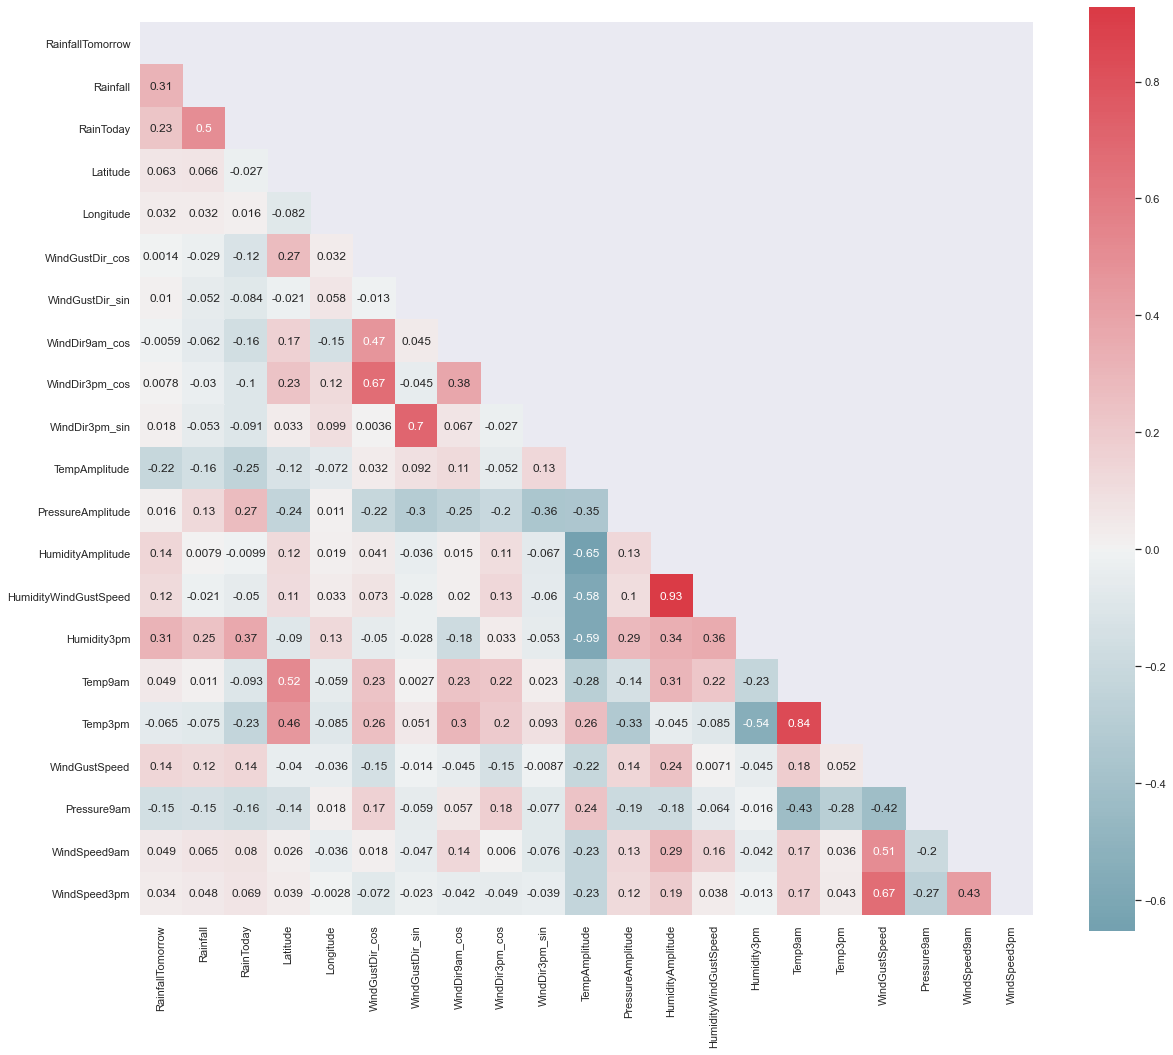

In [548]:
plot_corrMatrix(preprocessed_data, method = 'pearson')

In [549]:
preprocessed_data.drop(columns = ['HumidityWindGustSpeed', 'Temp9am'], inplace = True)

In [550]:
preprocessed_data.to_pickle('./regressor_train_set.pkl')

# TEST SET - CLASSIFIER

In [551]:
test_set = pd.concat([X_test, y_test], axis=1)

In [552]:
preprocessed_testset = PreProcessing_Pipeline.transform(test_set)


 BinaryEncodig() transform called.


 OutliersDetection() transform called.


 GeographicalCoords() transform called.


 FeatureScalling() transform called.


 CustomMeanTransformer() transform called. 



C:\Users\alexb\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(



 KNNCustomImputer() transform called.


 CircleEncoding_KNNImputer() transform called.


 VariableSelectionRegressor() transform called.


 FeatureScalling() transform called.



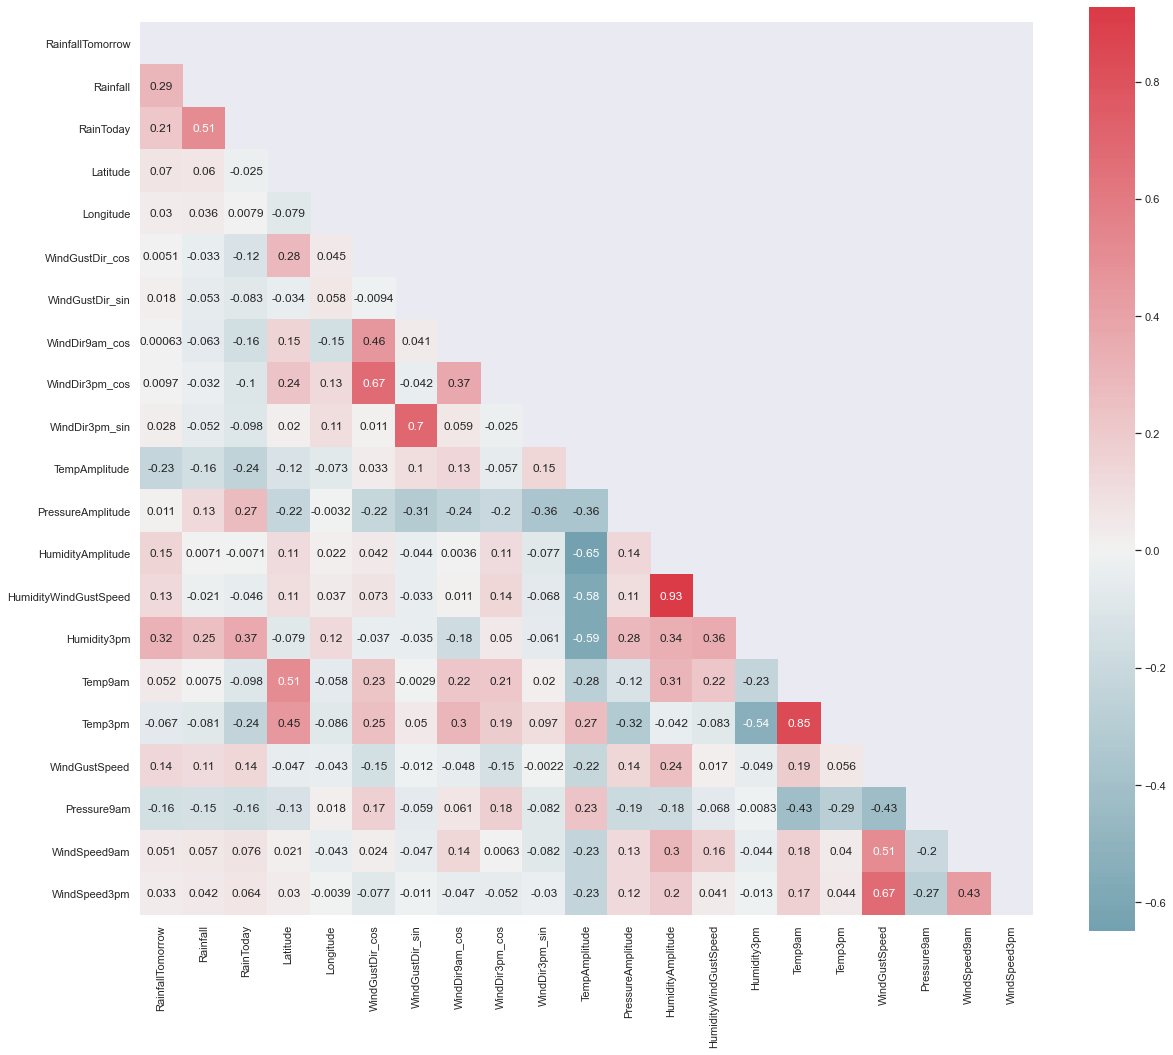

In [553]:
plot_corrMatrix(preprocessed_testset, method = 'pearson')

In [554]:
#preprocessed_testset.drop(columns = 'Pressure9am KNNindicator', inplace = True)
preprocessed_testset.drop(columns = ['HumidityWindGustSpeed', 'Temp9am'], inplace = True)

In [555]:
preprocessed_testset.to_pickle('./regressor_test_set.pkl')